In [314]:
%load_ext autoreload
%autoreload 2

In [332]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

In [333]:
# lituahnia missing from oxcgrt
# malaysia missing from ours
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("South Korea", "KR", "KOR"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    #("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Poland","PL", "POL"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF")
]

region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_oxcgrt = list([x for _, _, x in region_info])

print(f"Region Info\n--------------\n{len(region_info)} countries")
for name, epimodel_code, oxcgrt_code in region_info:
    print(f" Name: {name[:12]:12s}   Epimodel Code: {epimodel_code}. OxCGRT Code: {oxcgrt_code}")

Region Info
--------------
33 countries
 Name: Andorra        Epimodel Code: AD. OxCGRT Code: AND
 Name: Austria        Epimodel Code: AT. OxCGRT Code: AUT
 Name: Bosnia and H   Epimodel Code: BA. OxCGRT Code: BIH
 Name: Belgium        Epimodel Code: BE. OxCGRT Code: BEL
 Name: Bulgaria       Epimodel Code: BG. OxCGRT Code: BGR
 Name: Switzerland    Epimodel Code: CH. OxCGRT Code: CHE
 Name: Czech Republ   Epimodel Code: CZ. OxCGRT Code: CZE
 Name: Germany        Epimodel Code: DE. OxCGRT Code: DEU
 Name: Denmark        Epimodel Code: DK. OxCGRT Code: DNK
 Name: Estonia        Epimodel Code: EE. OxCGRT Code: EST
 Name: Spain          Epimodel Code: ES. OxCGRT Code: ESP
 Name: Finland        Epimodel Code: FI. OxCGRT Code: FIN
 Name: France         Epimodel Code: FR. OxCGRT Code: FRA
 Name: United Kingd   Epimodel Code: GB. OxCGRT Code: GBR
 Name: Greece         Epimodel Code: GR. OxCGRT Code: GRC
 Name: Croatia        Epimodel Code: HR. OxCGRT Code: HRV
 Name: Hungary        Epimodel C

In [334]:
epifor_filtered_df = epifor_data.loc[regions_epi, epifor_features]
ActiveCM_epi = epifor_filtered_df
print(ActiveCM_epi.loc[Ds])

Empty DataFrame
Columns: [Mask wearing over 70%, Business suspended - some, Business suspended - many, Healthcare specialisation]
Index: []


In [335]:
Ds

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-02 00:00:00+00:00',
               '2020-01-03 00:00:00+00:00', '2020-01-04 00:00:00+00:00',
               '2020-01-05 00:00:00+00:00', '2020-01-06 00:00:00+00:00',
               '2020-01-07 00:00:00+00:00', '2020-01-08 00:00:00+00:00',
               '2020-01-09 00:00:00+00:00', '2020-01-10 00:00:00+00:00',
               ...
               '2020-04-16 00:00:00+00:00', '2020-04-17 00:00:00+00:00',
               '2020-04-18 00:00:00+00:00', '2020-04-19 00:00:00+00:00',
               '2020-04-20 00:00:00+00:00', '2020-04-21 00:00:00+00:00',
               '2020-04-22 00:00:00+00:00', '2020-04-23 00:00:00+00:00',
               '2020-04-24 00:00:00+00:00', '2020-04-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=116, freq='D')

In [336]:
ActiveCM_epi

,,Mask wearing over 70%,Business suspended - some,Business suspended - many,Healthcare specialisation
Code,Date,,,,
AT,2019-12-18 00:00:00+00:00,0.0,0.0,0.0,0.0
DE,2019-12-18 00:00:00+00:00,0.0,0.0,0.0,0.0
GB,2019-12-18 00:00:00+00:00,0.0,0.0,0.0,0.0
KR,2019-12-18 00:00:00+00:00,0.0,0.0,0.0,0.0
SG,2019-12-18 00:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
RS,2020-04-23 00:00:00+00:00,0.0,1.0,1.0,0.0
CH,2020-04-23 00:00:00+00:00,0.0,1.0,1.0,0.0
MX,2020-04-23 00:00:00+00:00,0.0,1.0,1.0,0.0


In [337]:


# load OxCGRT csv
oxcgrt_path = "/Users/mrinank/workspace/epidemicforecasting/epimodel/data/OxCGRT_latest.csv"
date_column = "Date"
data = pd.read_csv(oxcgrt_path, index_col="CountryCode")

columns_to_drop = ["CountryName", "Date", "ConfirmedCases", "ConfirmedDeaths", 
                   "StringencyIndex", "StringencyIndexForDisplay",
                   "LegacyStringencyIndex", "LegacyStringencyIndexForDisplay"]

dti = pd.DatetimeIndex(pd.to_datetime(data[date_column], utc=True, format="%Y%m%d"))
epi_codes = [oxcgrt_to_epimodel_index(cc) for cc in data.index.array]
data.index = pd.MultiIndex.from_arrays([epi_codes, dti])

for col in columns_to_drop:
    del data[col]

data.sort_index()

all_values = data.loc[regions_epi].values

SelectedCMS = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

features = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
    ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
    ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
    ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

start_date = "2020-1-1"
end_date = "2020-04-20"
Ds = pd.date_range(start=start_date, end=end_date, tz="utc")



ActiveCMs_temp = np.stack([data_filtered.loc[c].loc[Ds].T for c in regions_epi])

nRs, _, nDs = ActiveCMs_temp.shape
nCMs = len(features)

ActiveCM_oxcgrt = np.zeros((nRs, nCMs, nDs))

for r_indx in range(nRs):
    for feature_indx, (_, feature_filter) in enumerate(features):
        nConditions = len(feature_filter)
        condition_mat = np.zeros((nConditions, nDs))
        for condition, (row, poss_values) in enumerate(feature_filter):
            row_vals = ActiveCMs_temp[r_indx, row, :]
            for value in poss_values:
                condition_mat[condition, :] += (row_vals == value)
            condition_mat[condition, :] = condition_mat[condition, :] > 0
        ActiveCM_oxcgrt[r_indx, feature_indx, :] = np.prod(condition_mat, axis=0) > 0
        
epifor_path = "/Users/mrinank/workspace/epidemicforecasting/epimodel/data/countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv"
epifor_data = pd.read_csv(epifor_path, index_col="Code")
dti = pd.DatetimeIndex(pd.to_datetime(epifor_data["Date"], utc=True))
epifor_data.index = pd.MultiIndex.from_arrays([epifor_data.index, dti])


oxcgrt_features = [n for n, l in features]
epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation'
]

epifor_filtered_df = epifor_data.loc[regions_epi, epifor_features]
ActiveCM_epi = np.stack([epifor_filtered_df.loc[c].loc[Ds].T for c in regions_epi])


final_features_ordered = [
    "Healthcare specialisation",
    "Symptomatic Testing",
    "Public Testing",
    "Limited Contact Tracing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Gatherings lim. 1000", 
    "Gatherings lim. 100",
    "Gatherings lim. 10", 
    "Business suspended - some",
    "Business suspended - many",
    "Some Schools Closed",
    "All Schools Closed", 
    "Stay at Home, Rec", 
    "Stay at Home, Req",
]

nCMs = len(final_features_ordered)

ActiveCMs = np.zeros((nRs, nCMs , nDs))

for r in range(nRs):
    for f_indx, f in enumerate(final_features_ordered):
        if f in epifor_features:
            ActiveCMs[r, f_indx, :] = ActiveCM_epi[r, epifor_features.index(f), :]
        else:
            ActiveCMs[r, f_indx, :] = ActiveCM_oxcgrt[r, oxcgrt_features.index(f), :]

# selected countries and features first

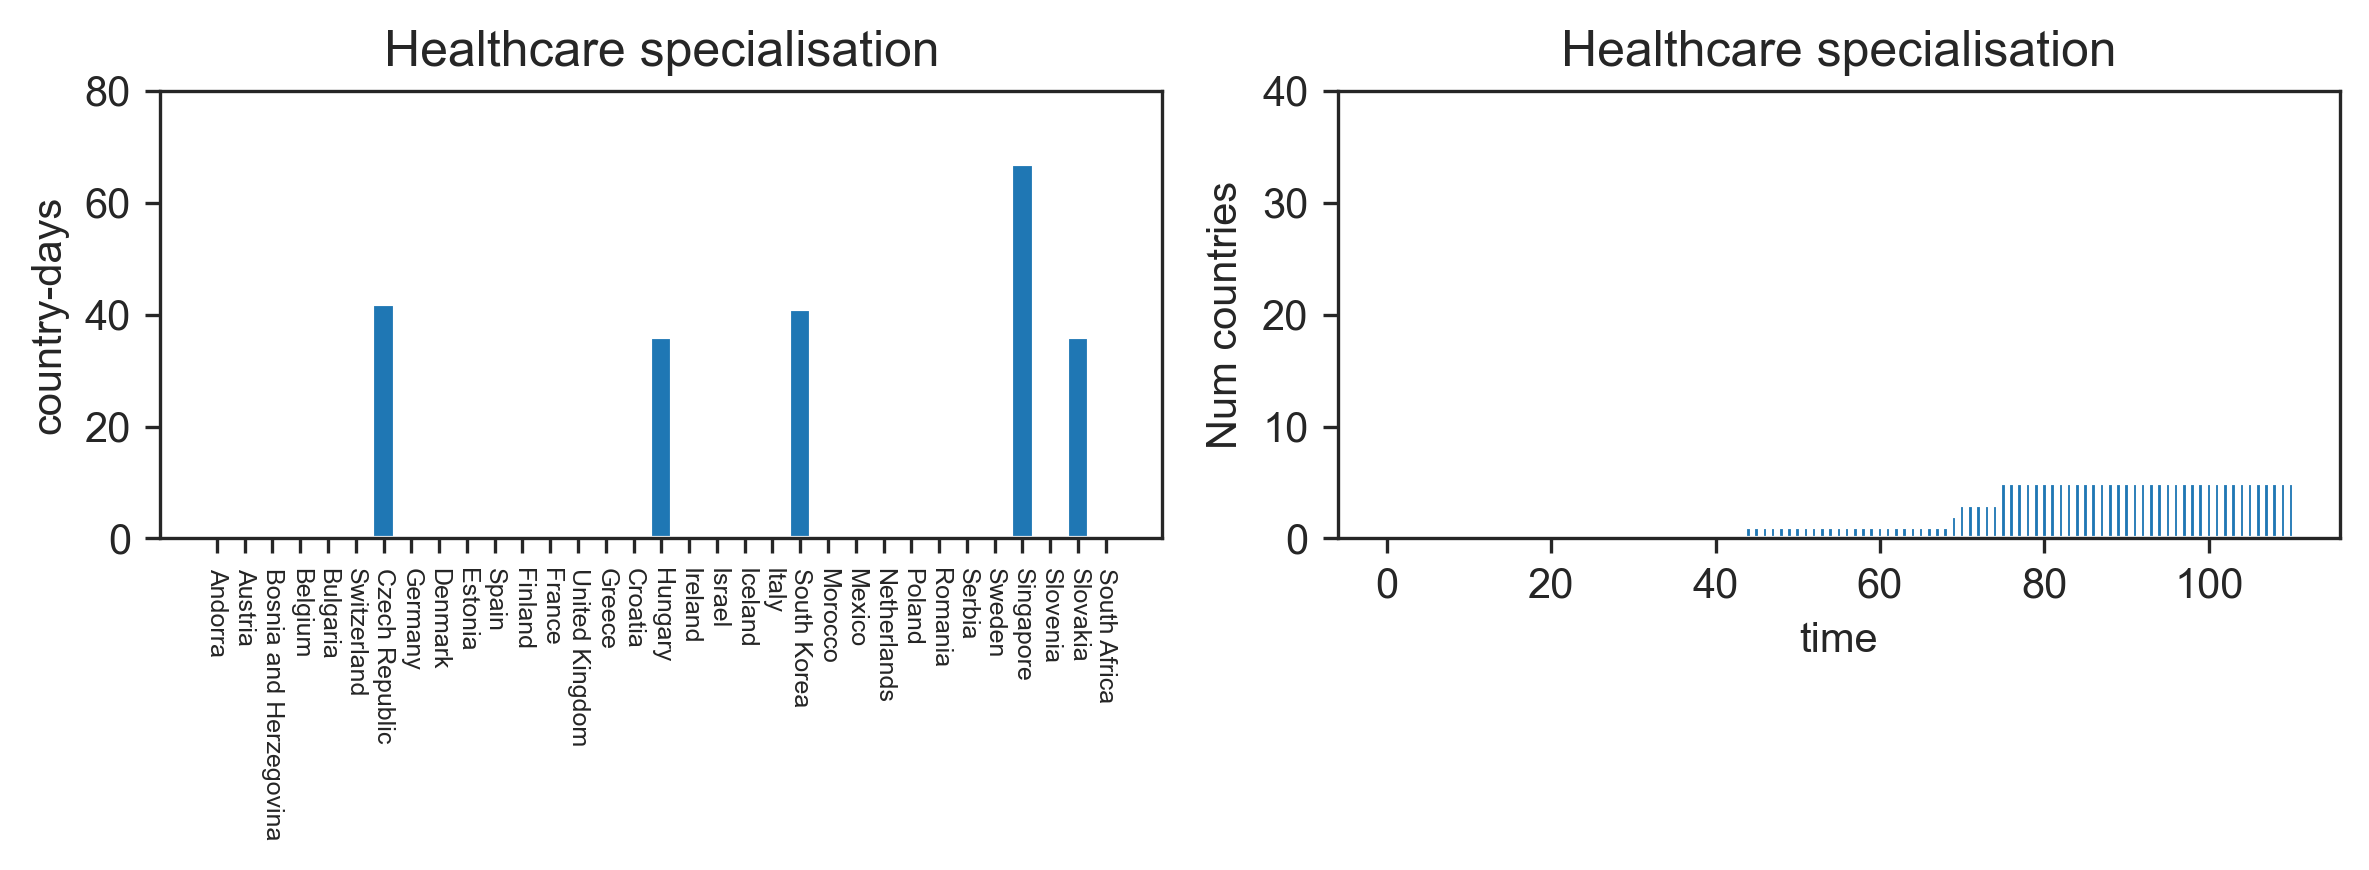

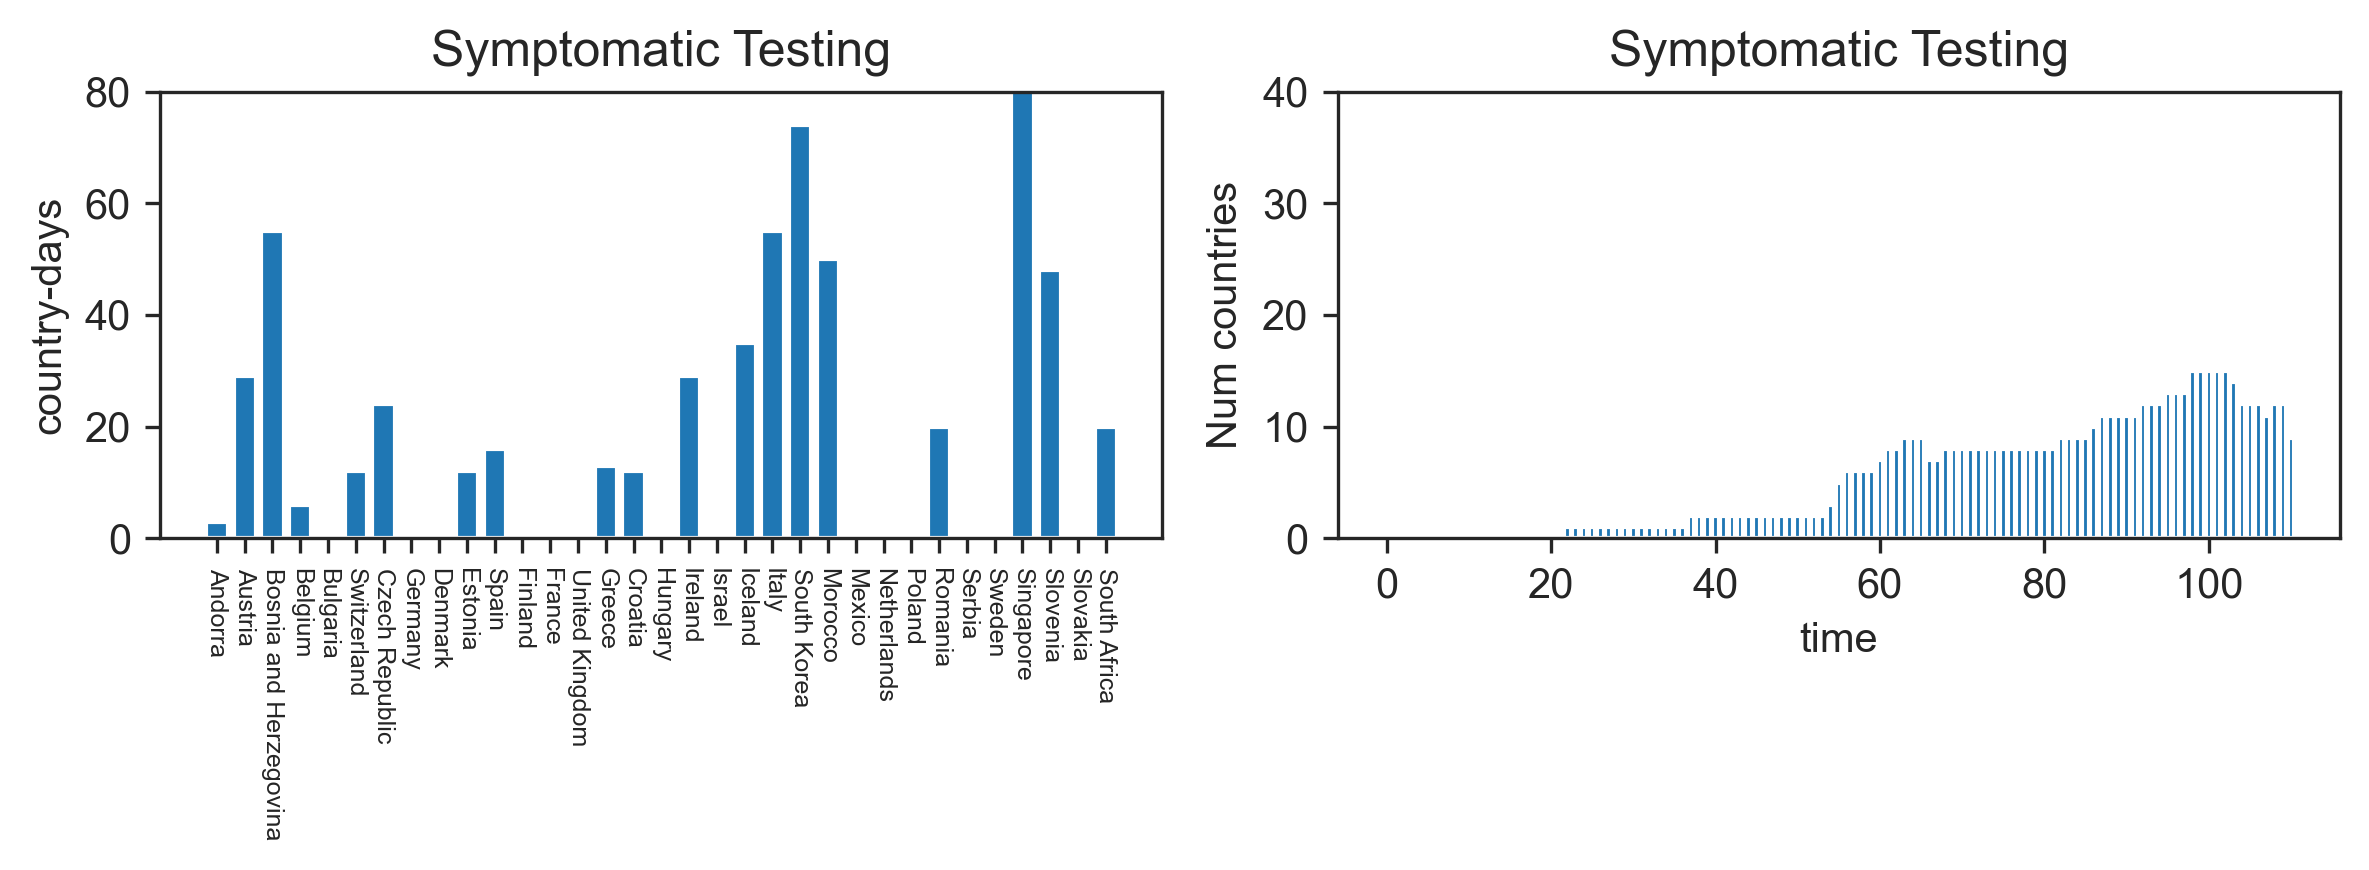

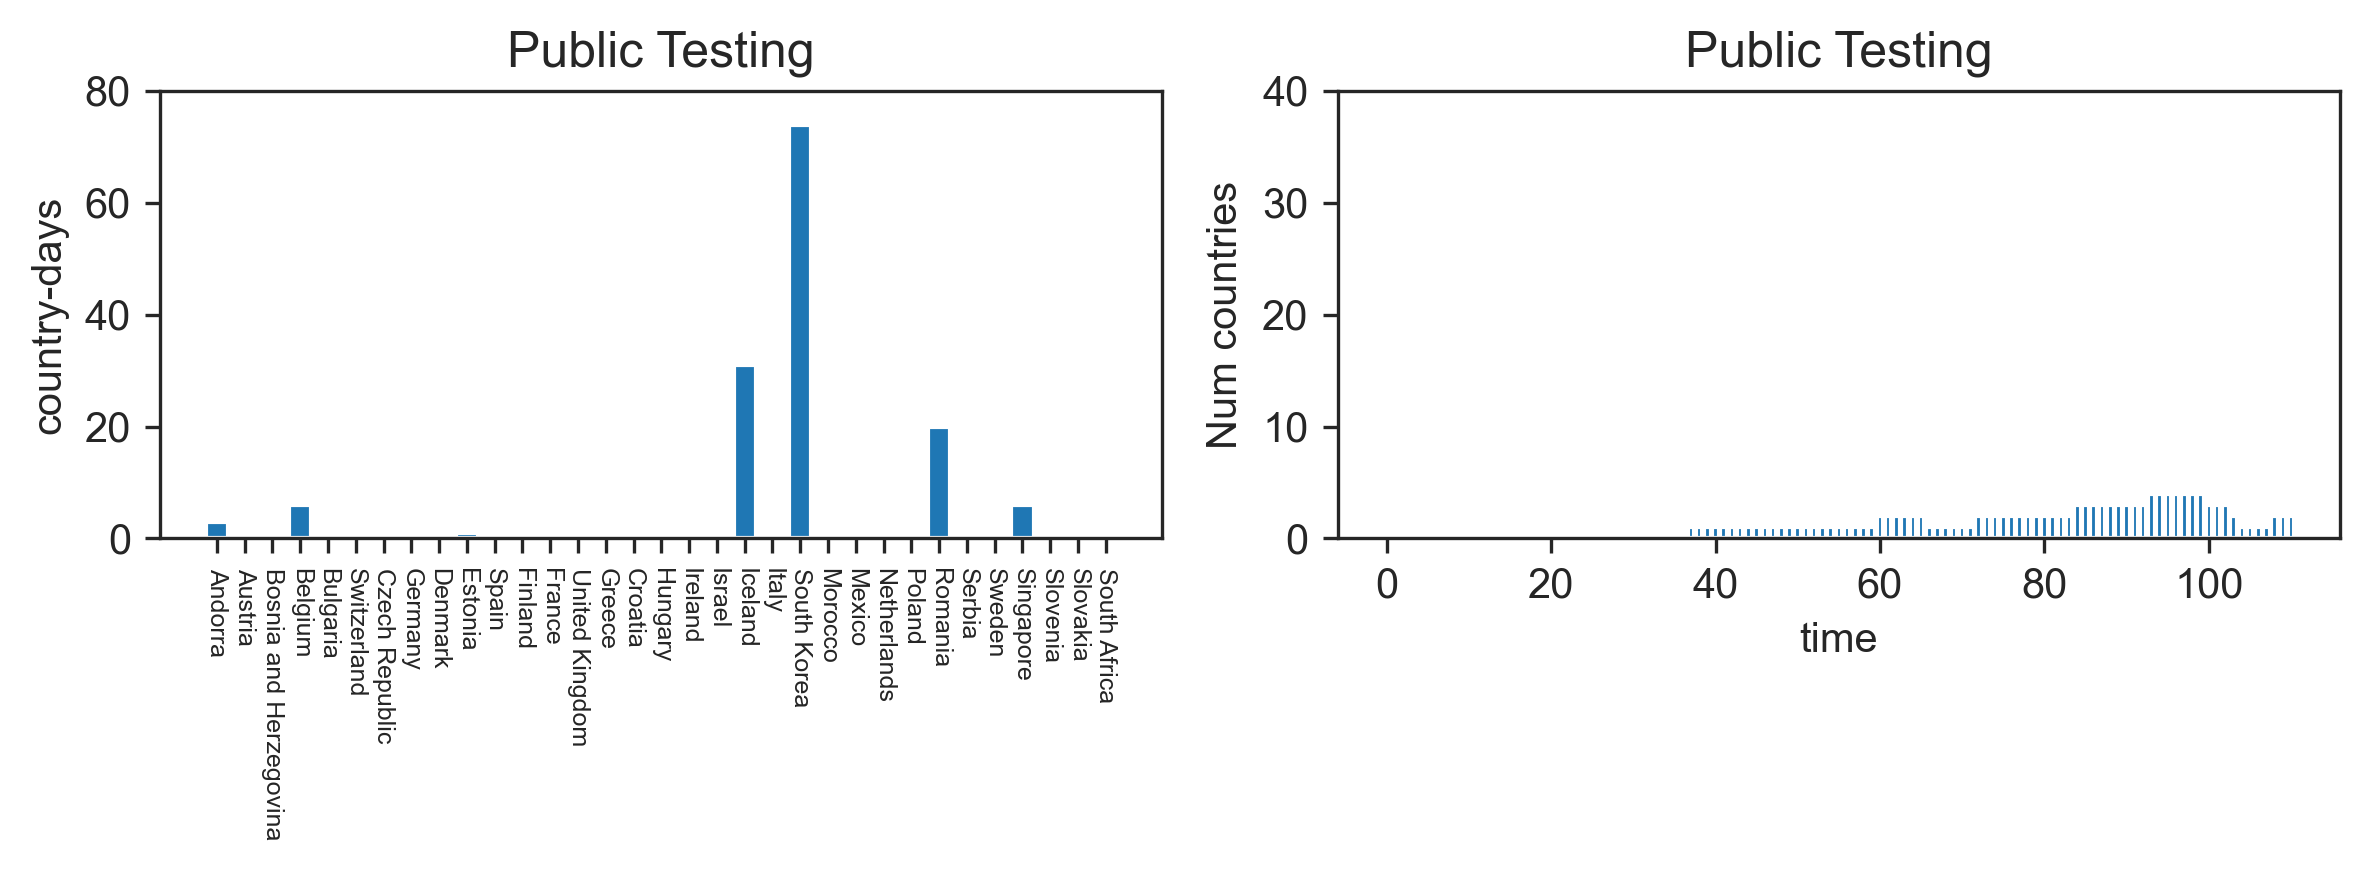

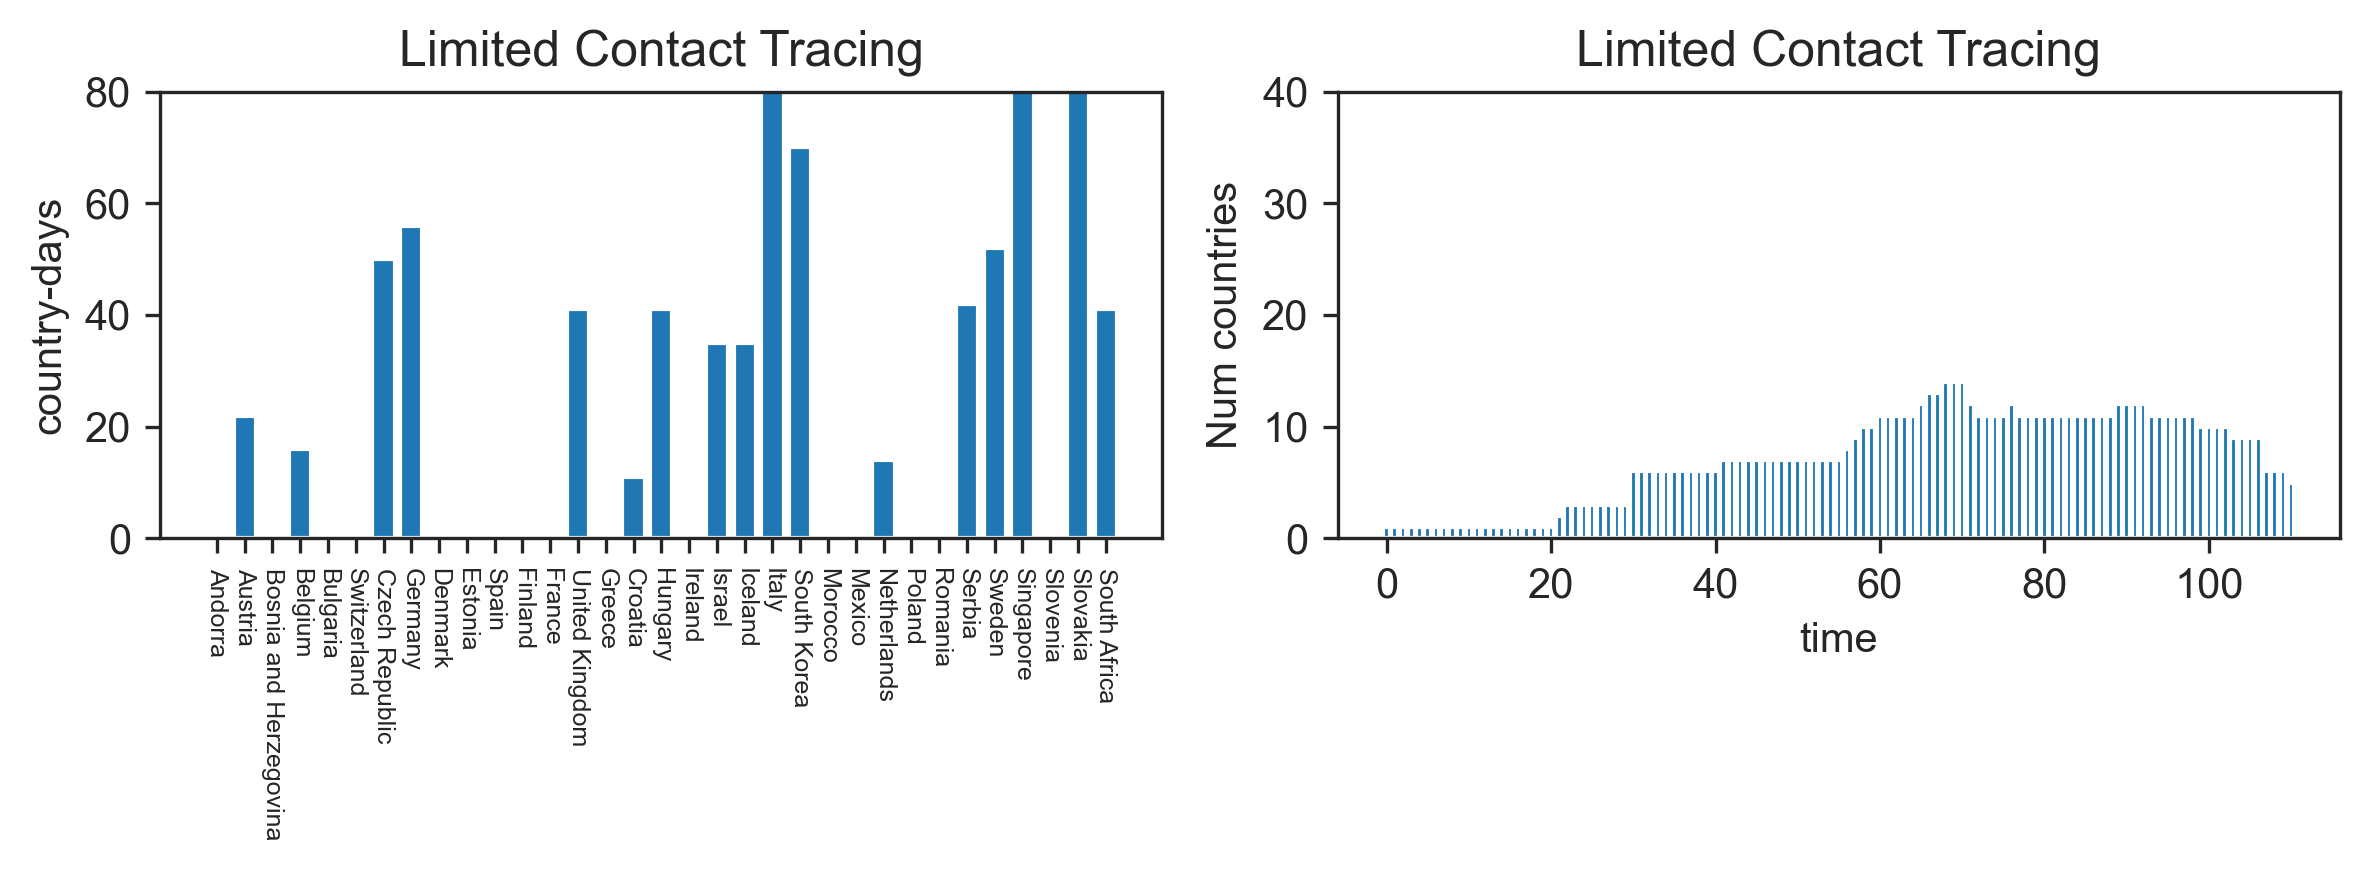

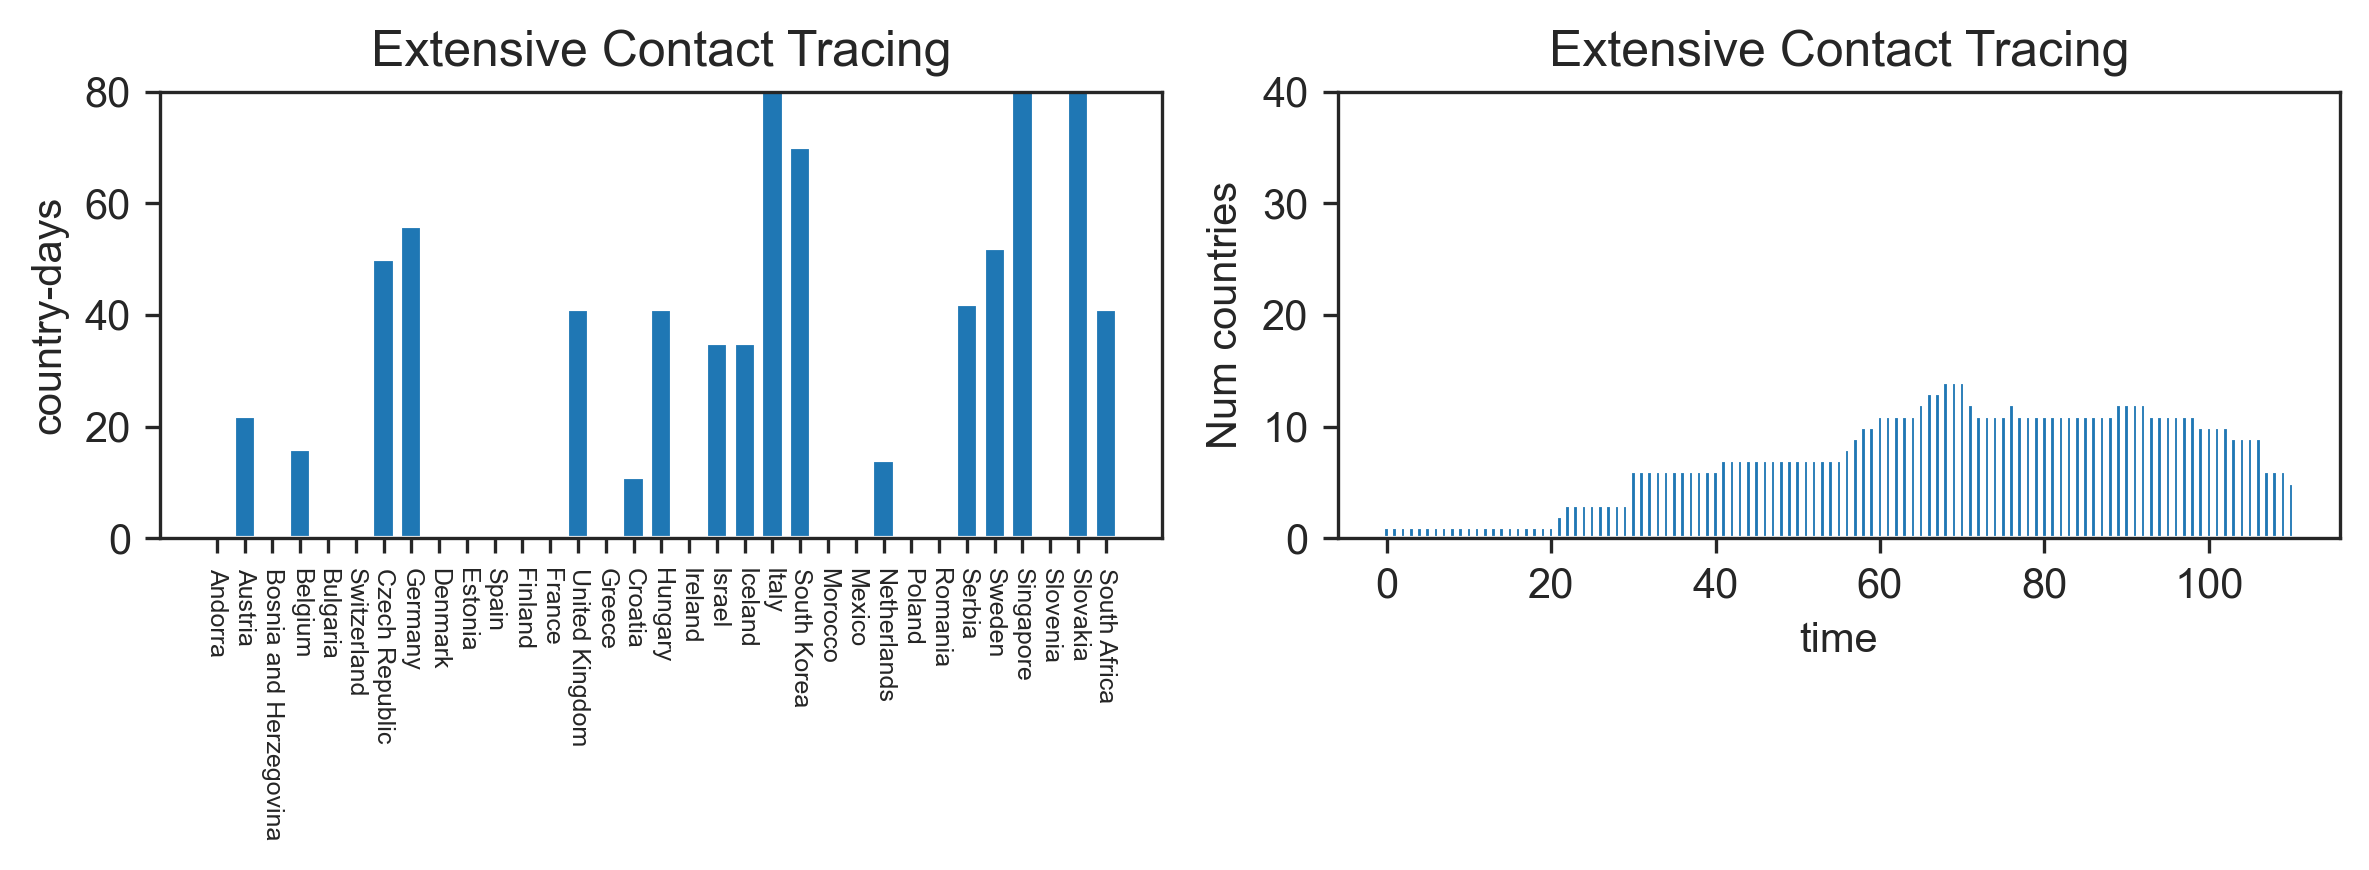

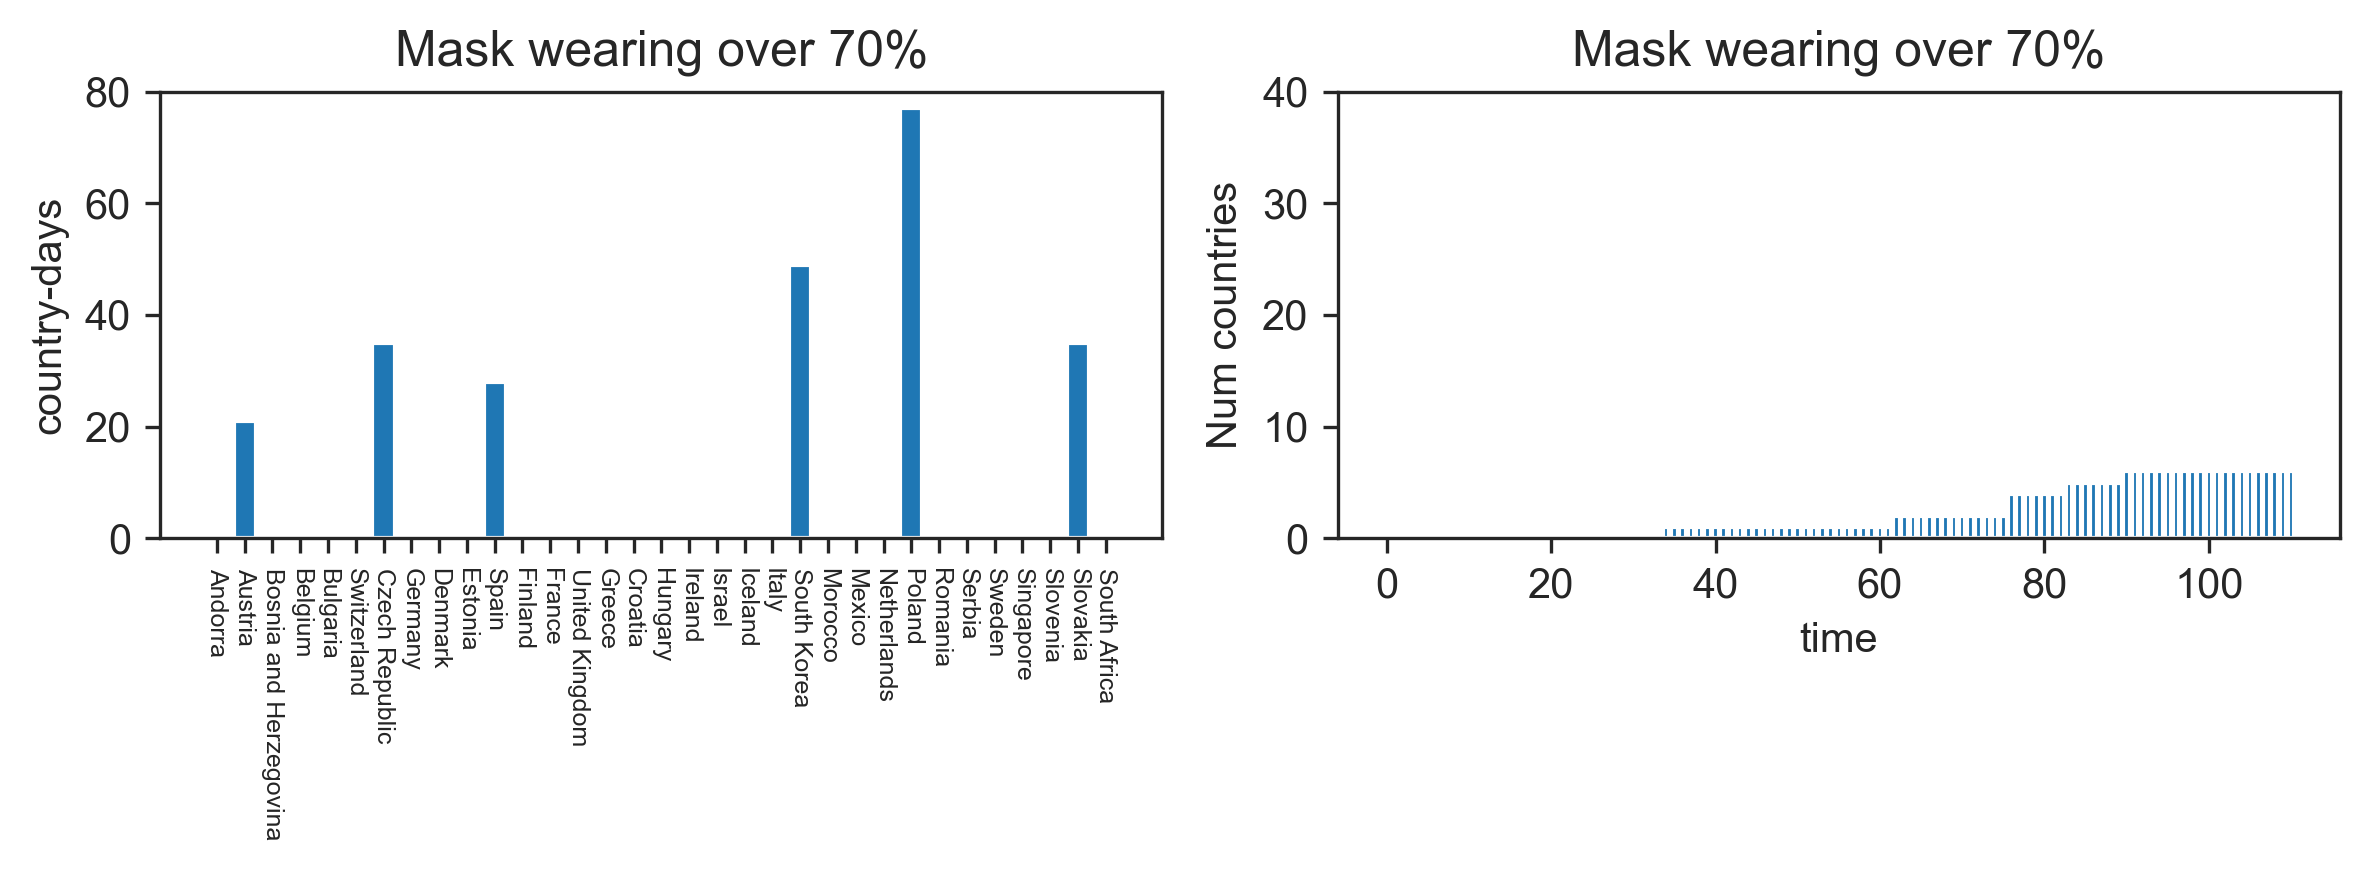

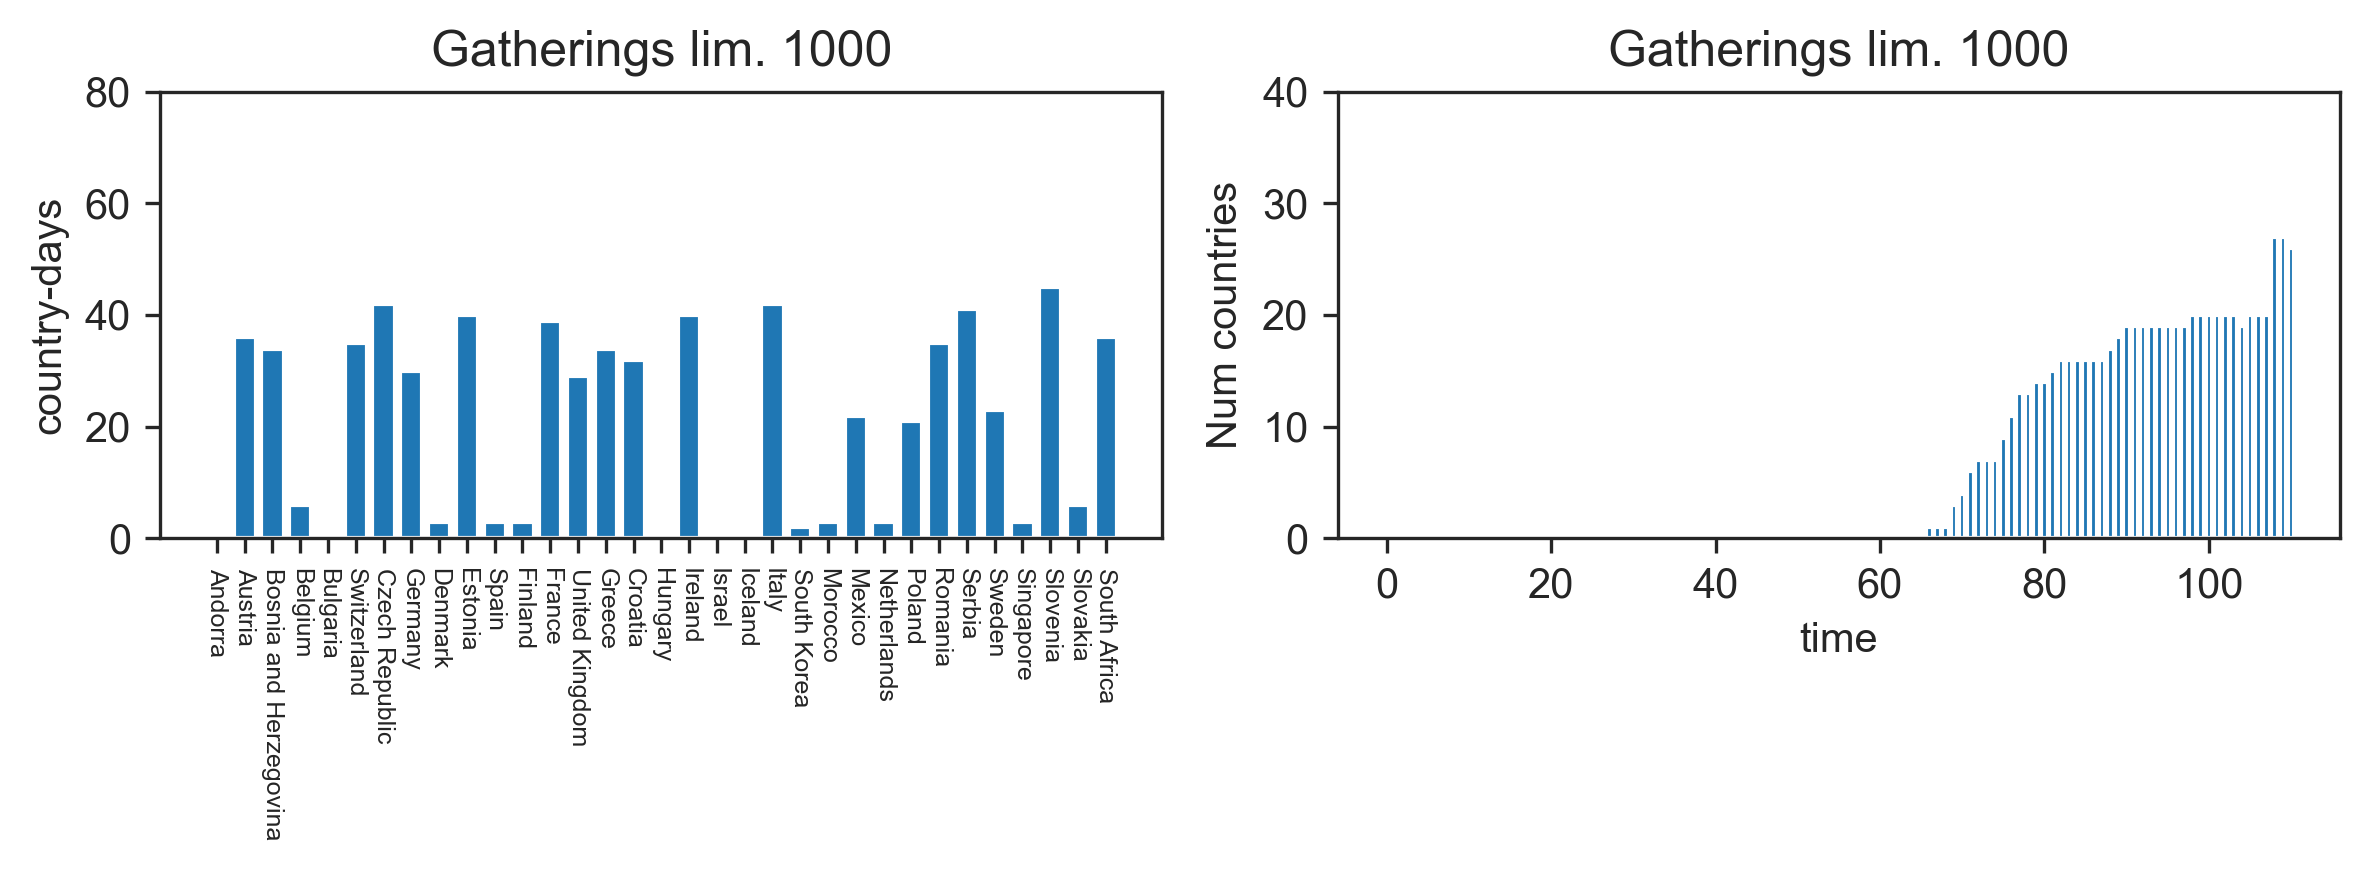

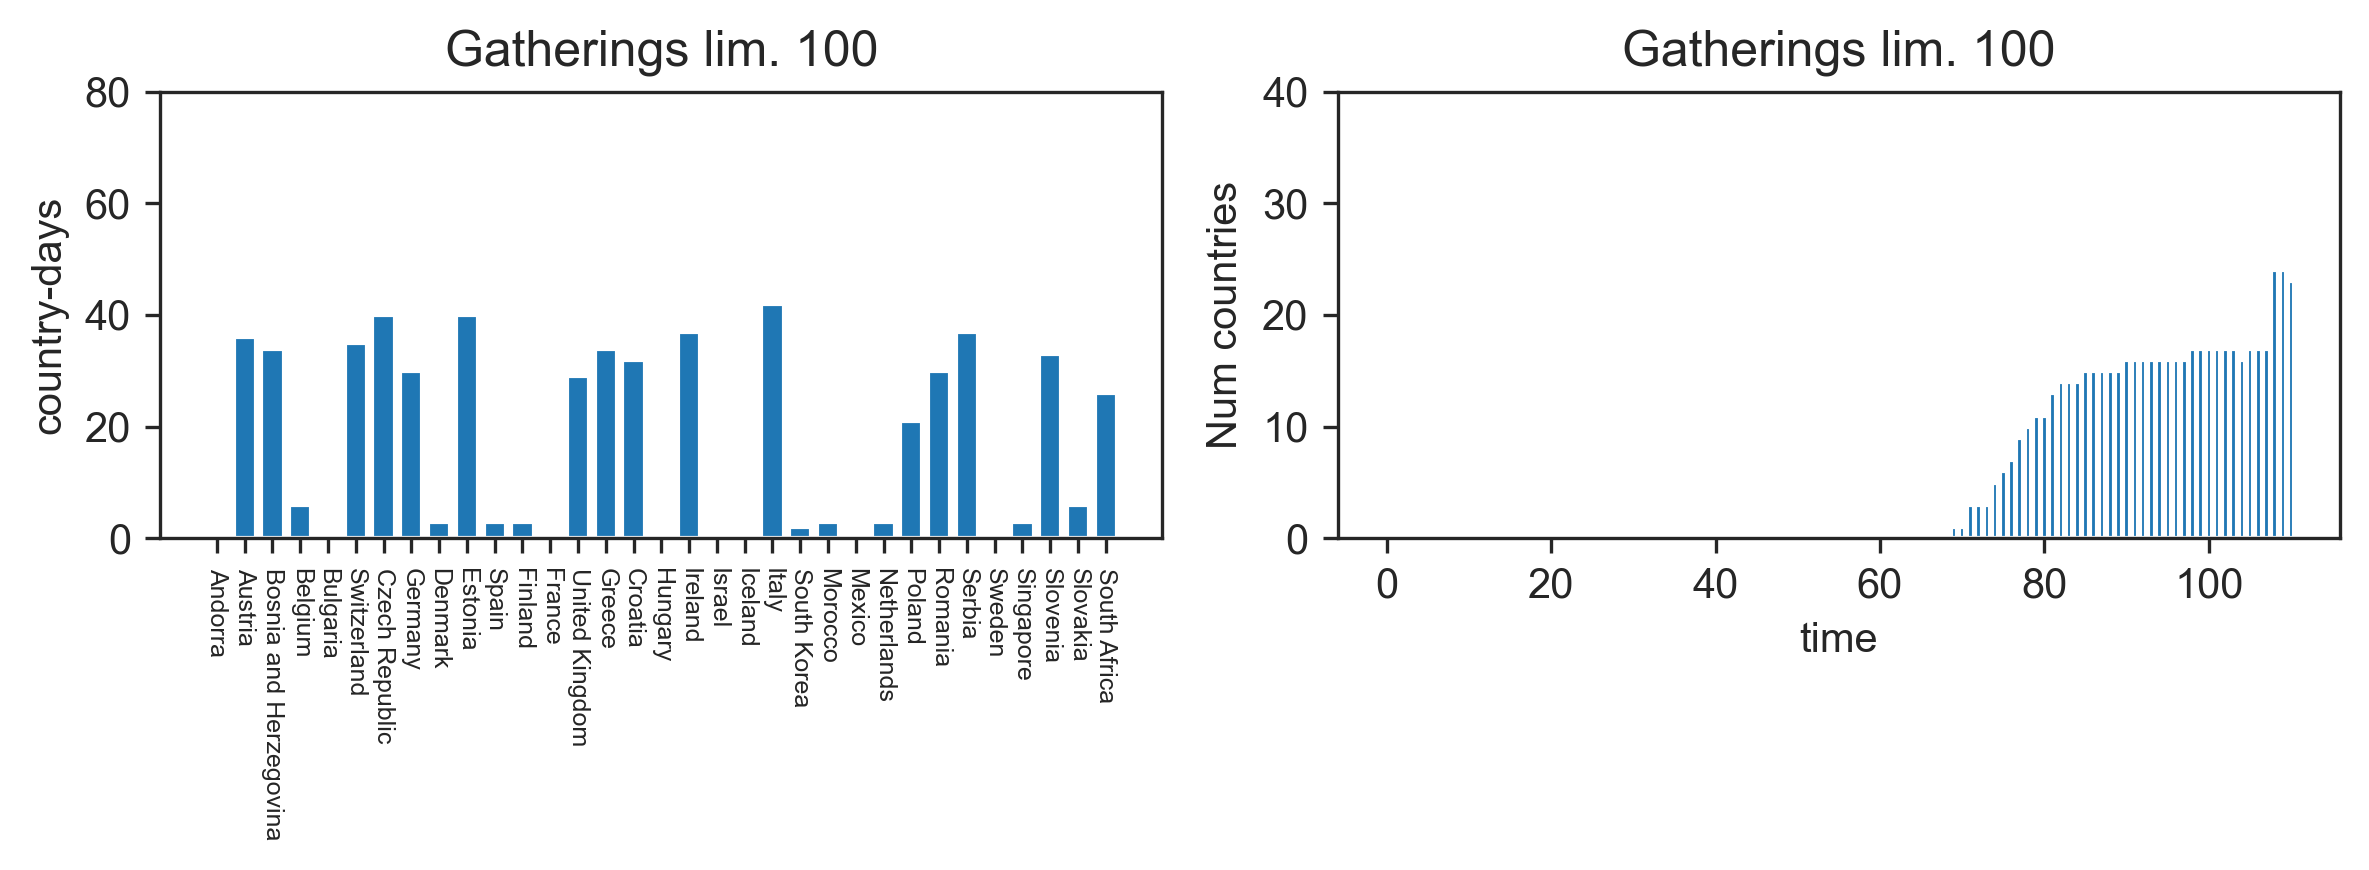

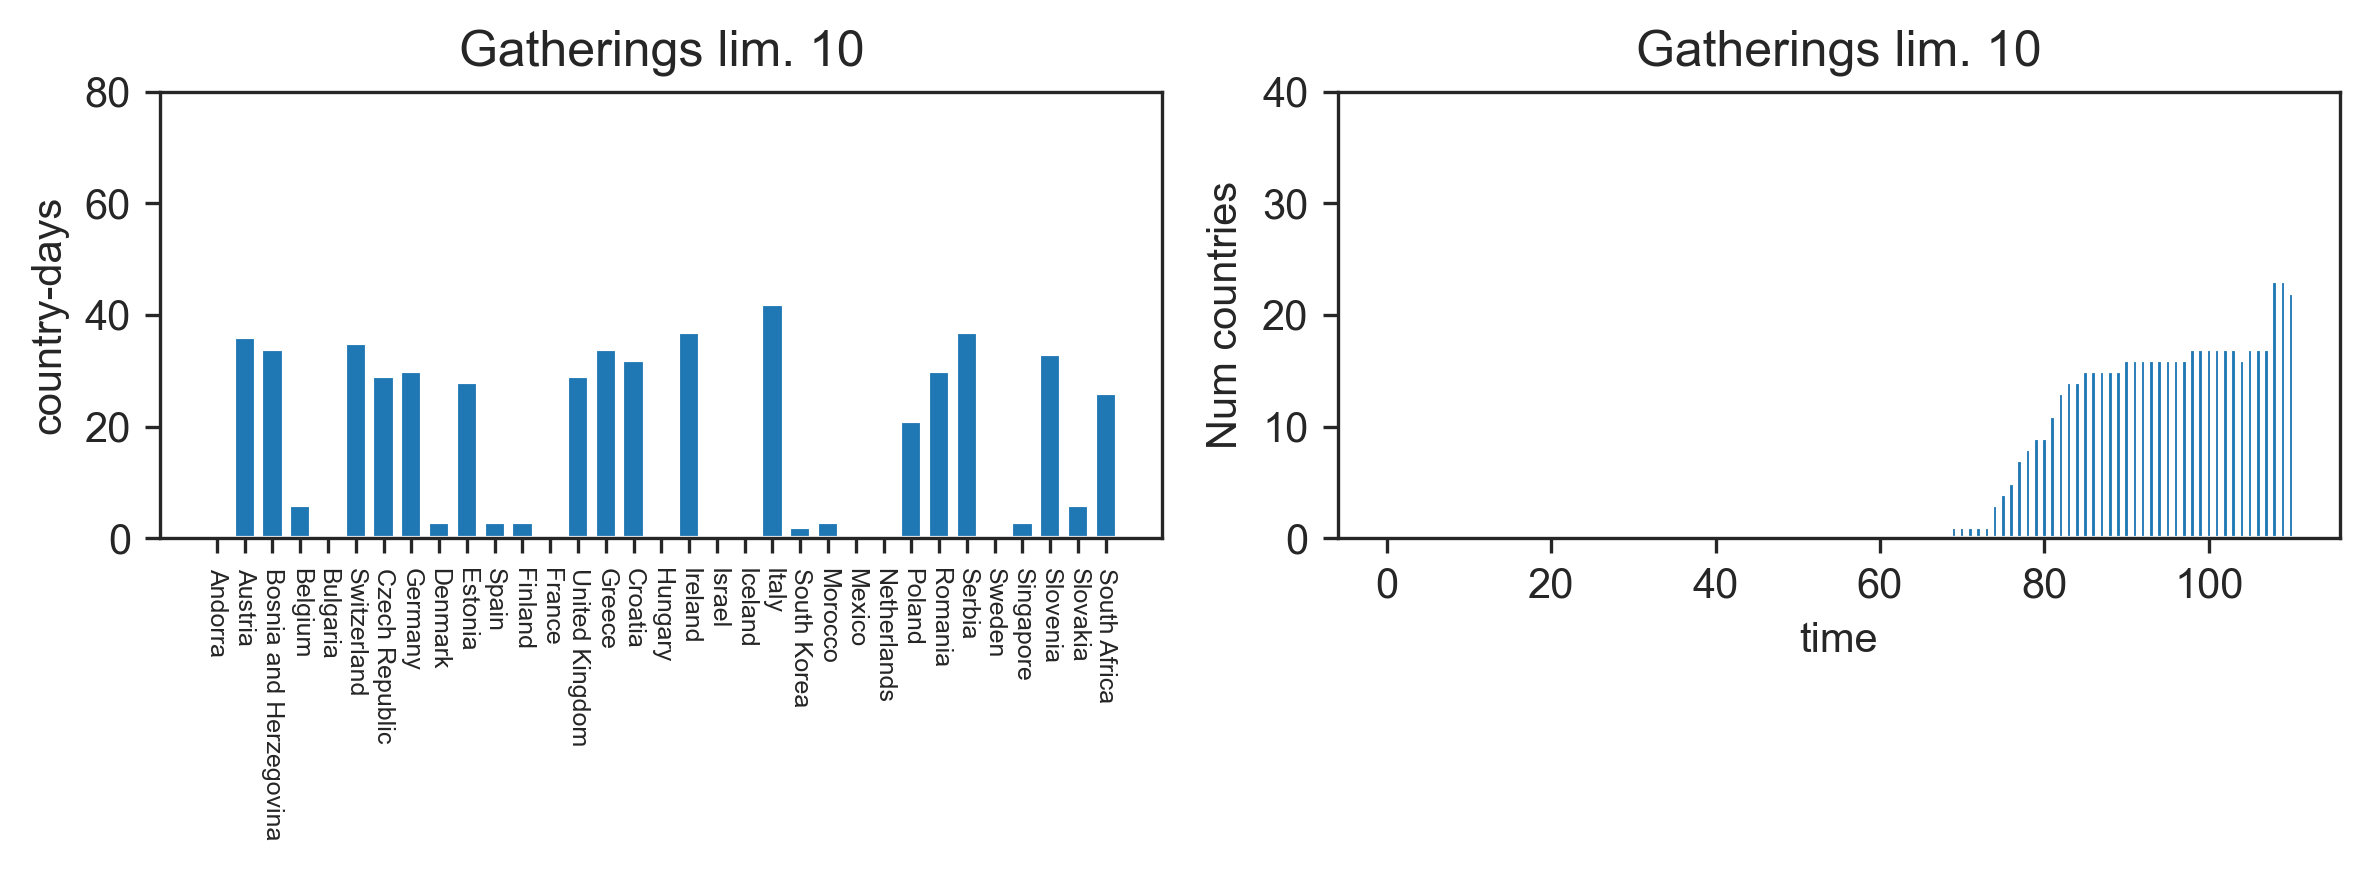

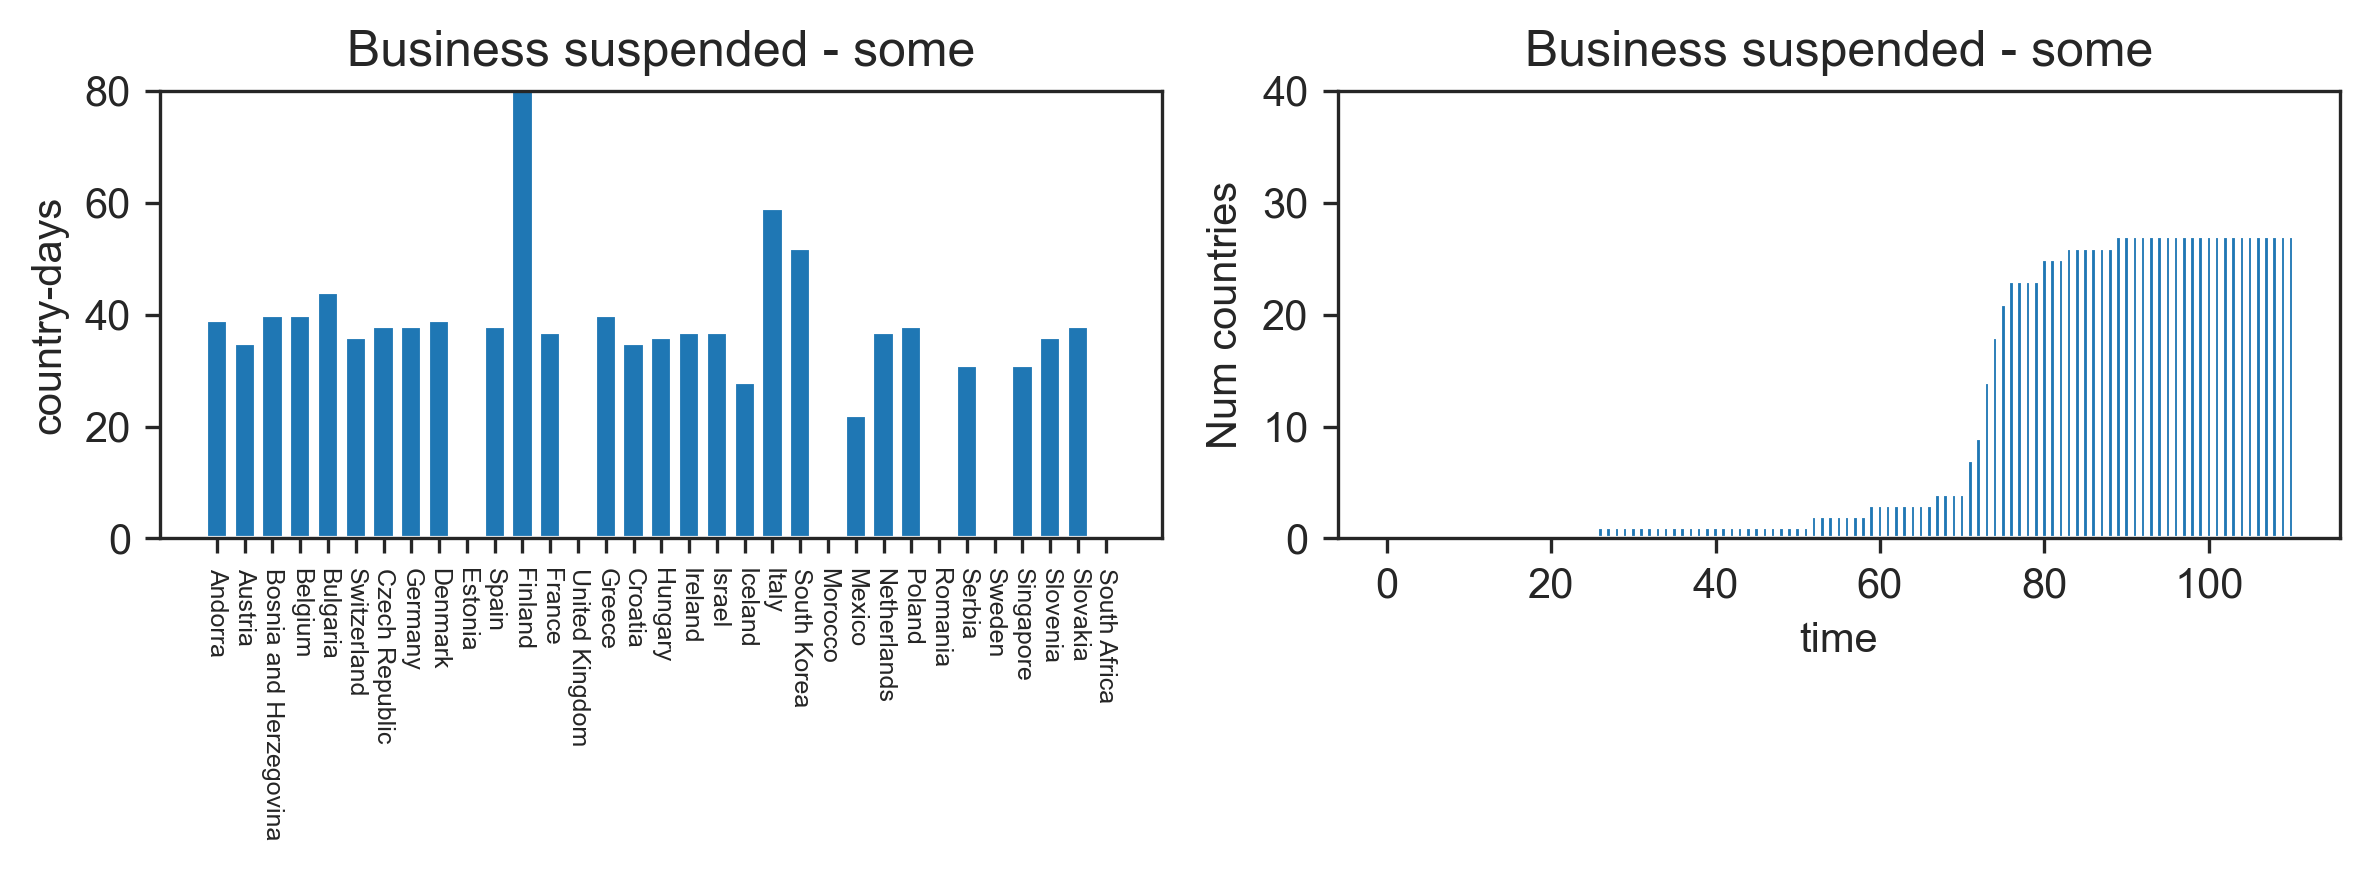

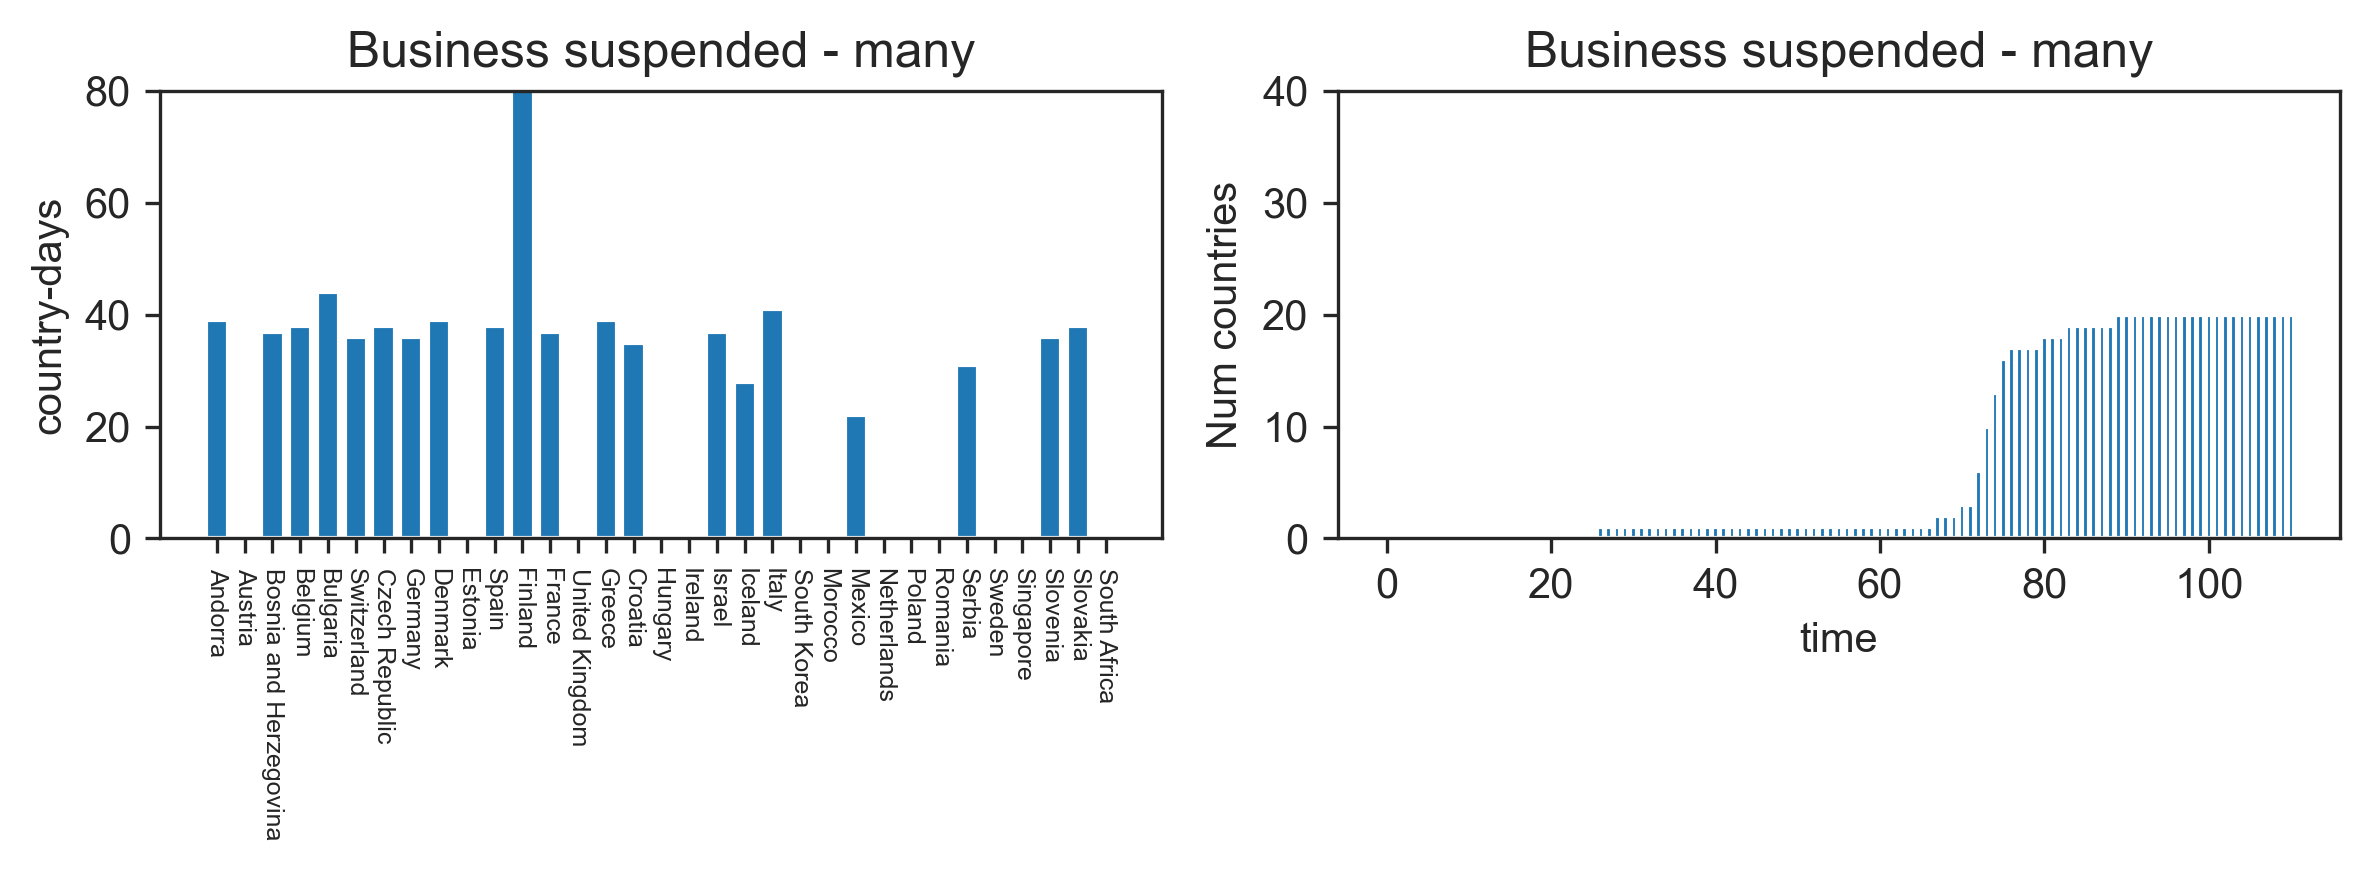

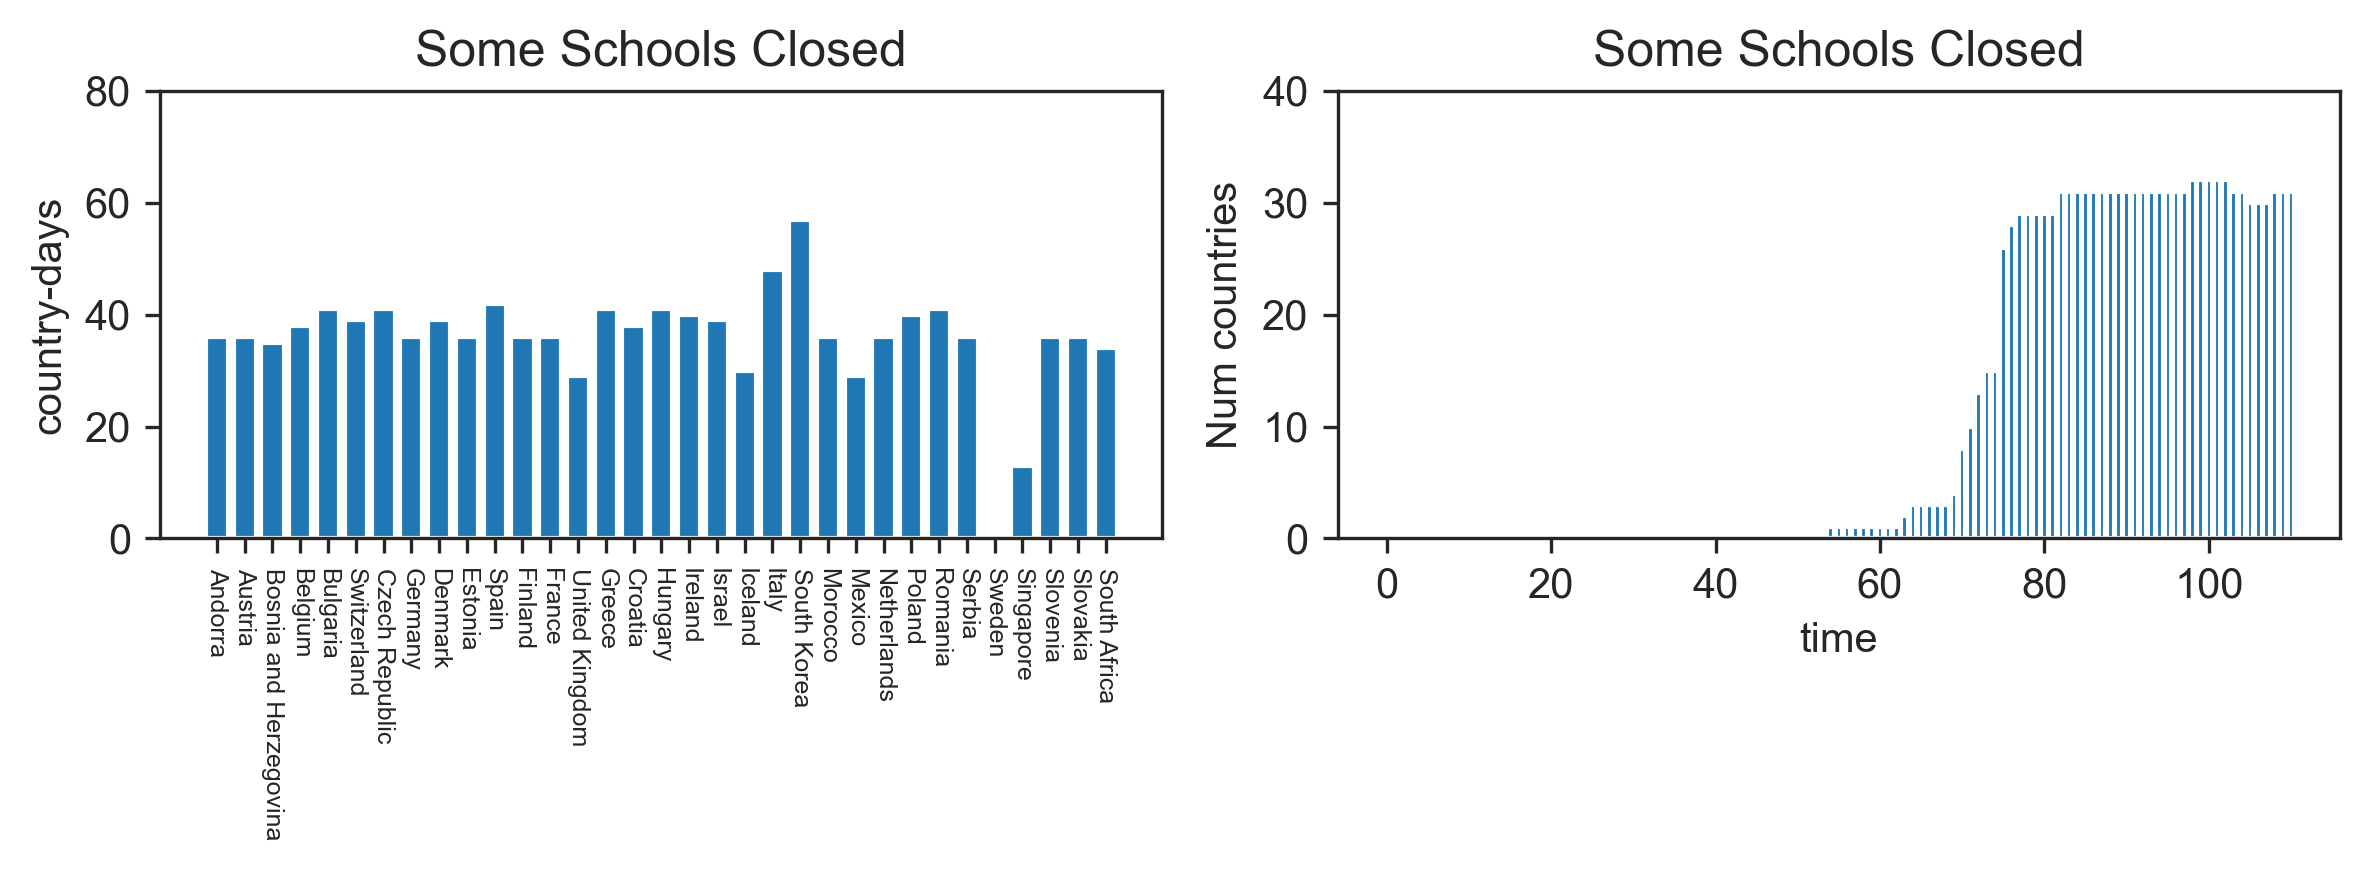

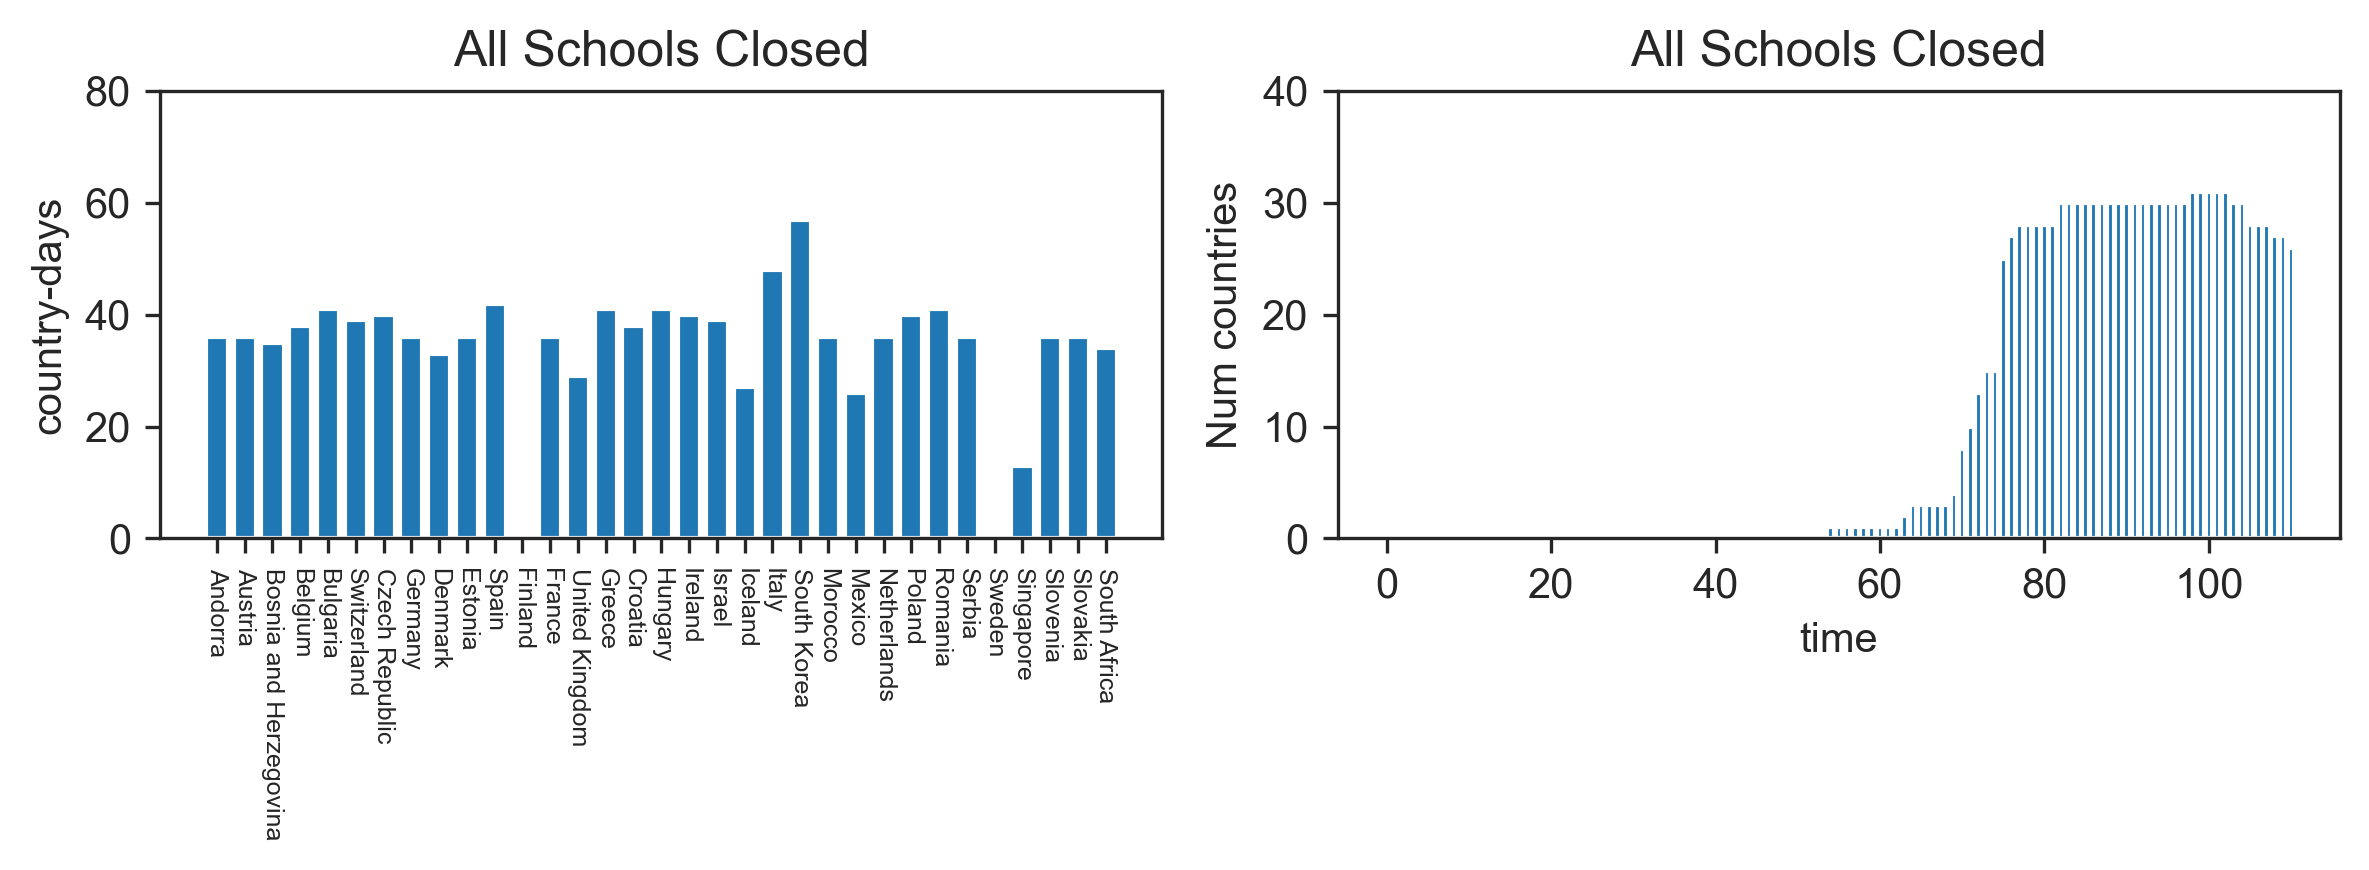

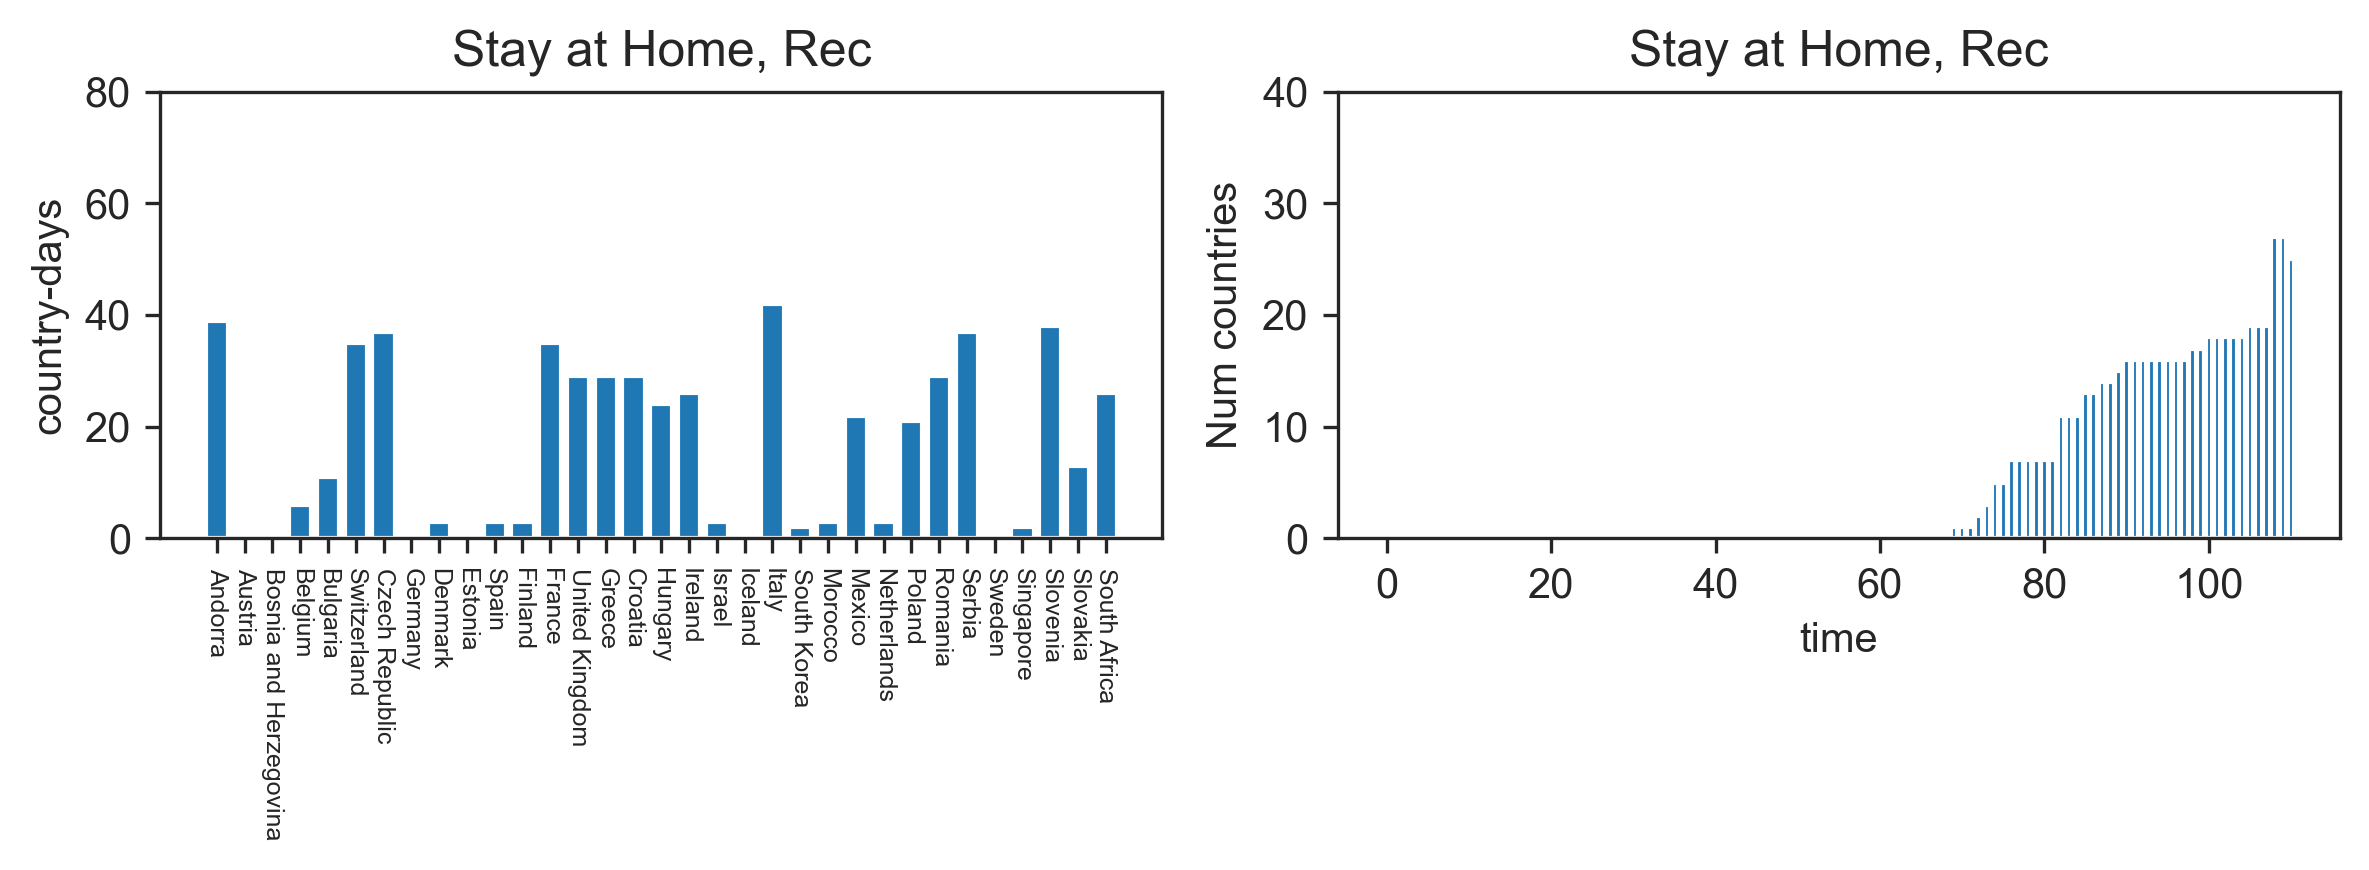

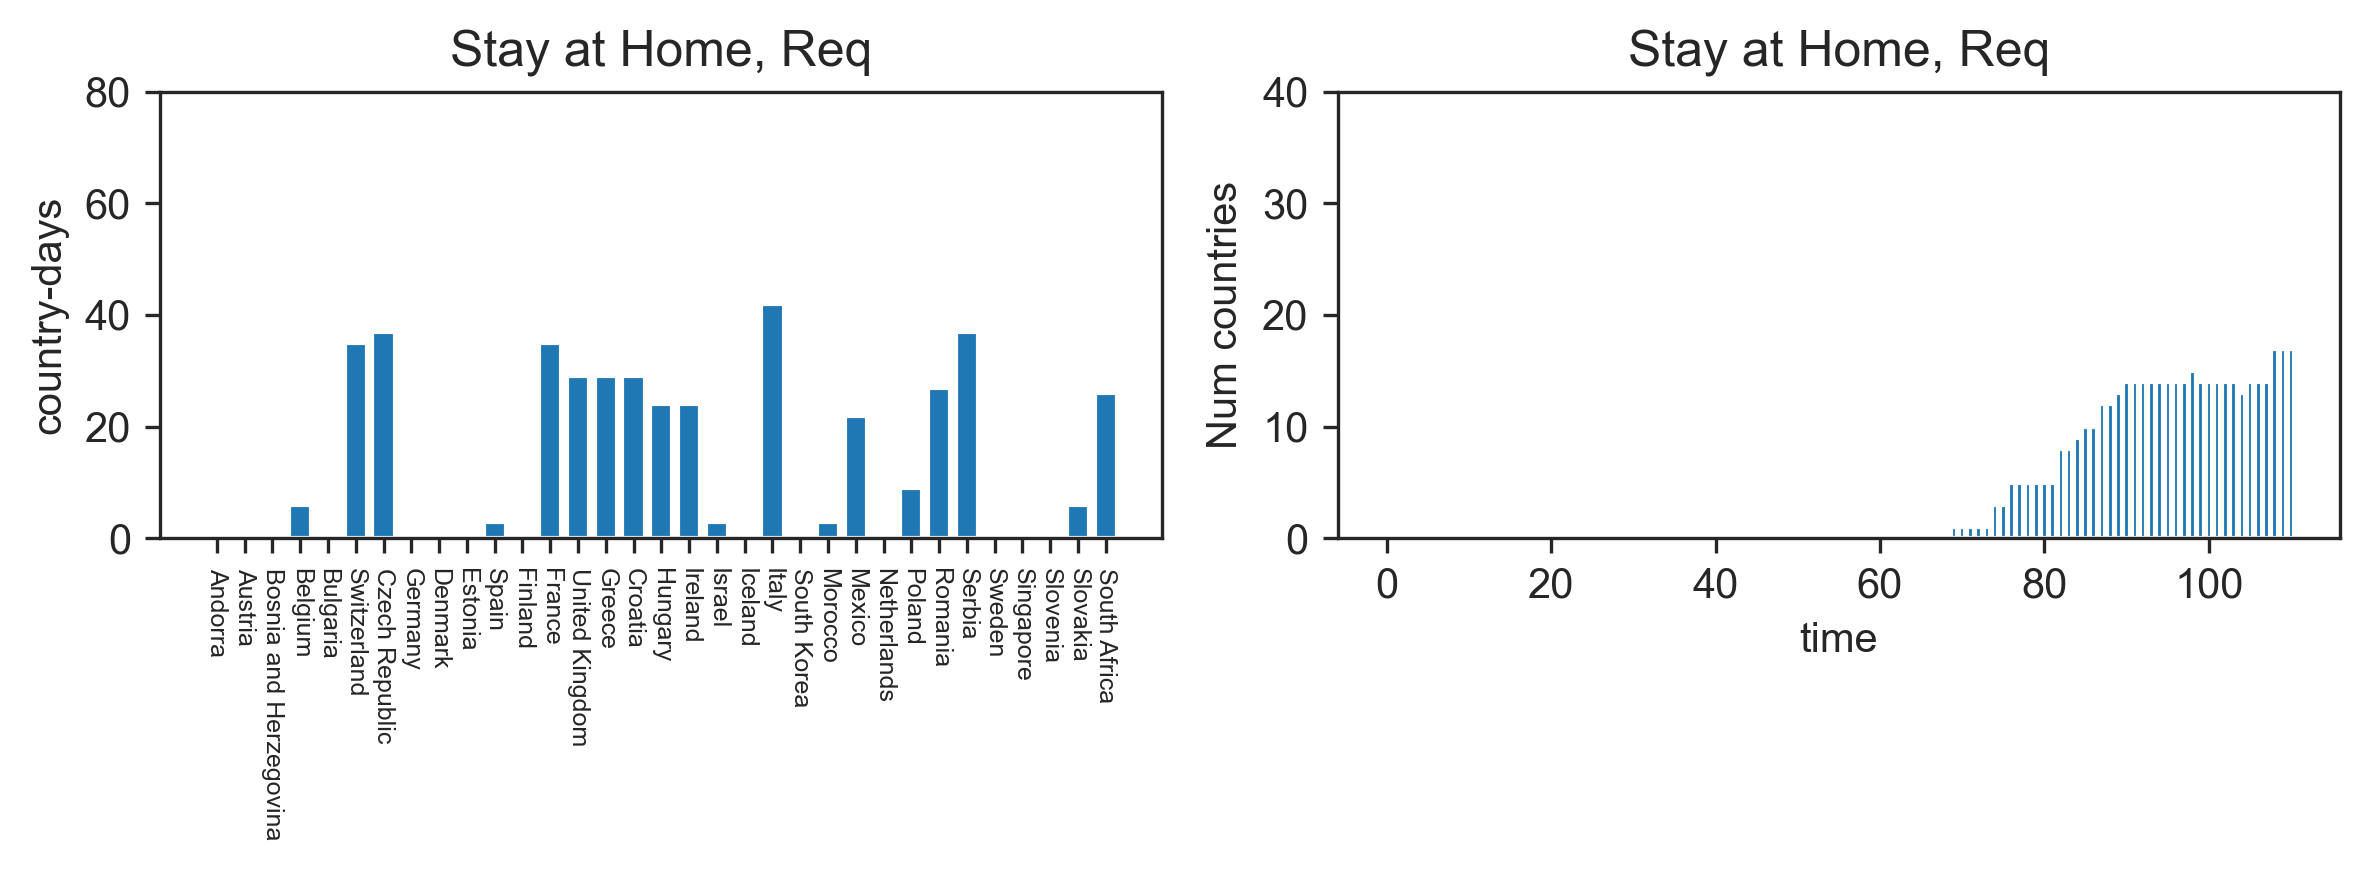

In [338]:
for indx, cm in enumerate(final_features_ordered):
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=1)
    plt.figure(figsize=(8, 3), dpi=300)
    plt.subplot(121)
    plt.bar(np.arange(len(region_names)), hist_data)
    plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
    plt.ylim([0, 80])
    plt.ylabel("country-days")
    plt.title(cm)
    plt.subplot(122)
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=0)
    plt.bar(np.arange(hist_data.size), hist_data)
    plt.title(cm)
    plt.ylim([0, 40])
    plt.ylabel("Num countries")
    plt.xlabel("time")
    plt.tight_layout()

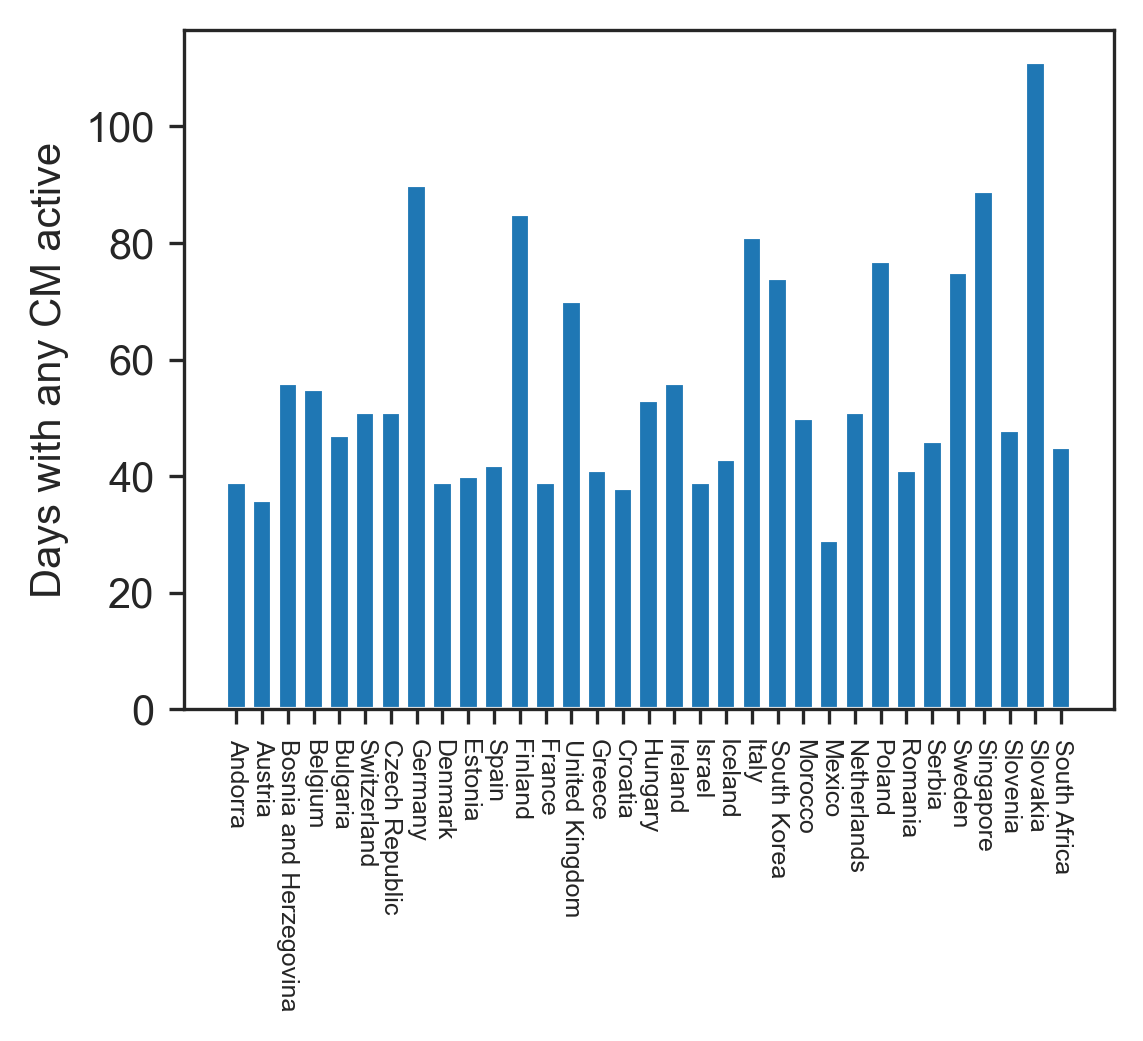

In [339]:
plt.figure(figsize=(4, 3), dpi=300)
cs = np.sum(np.sum(ActiveCMs[:, :, :], axis=1) > 0, axis=-1)
plt.bar(np.arange(len(region_names)), cs)
plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
plt.ylabel("Days with any CM active");

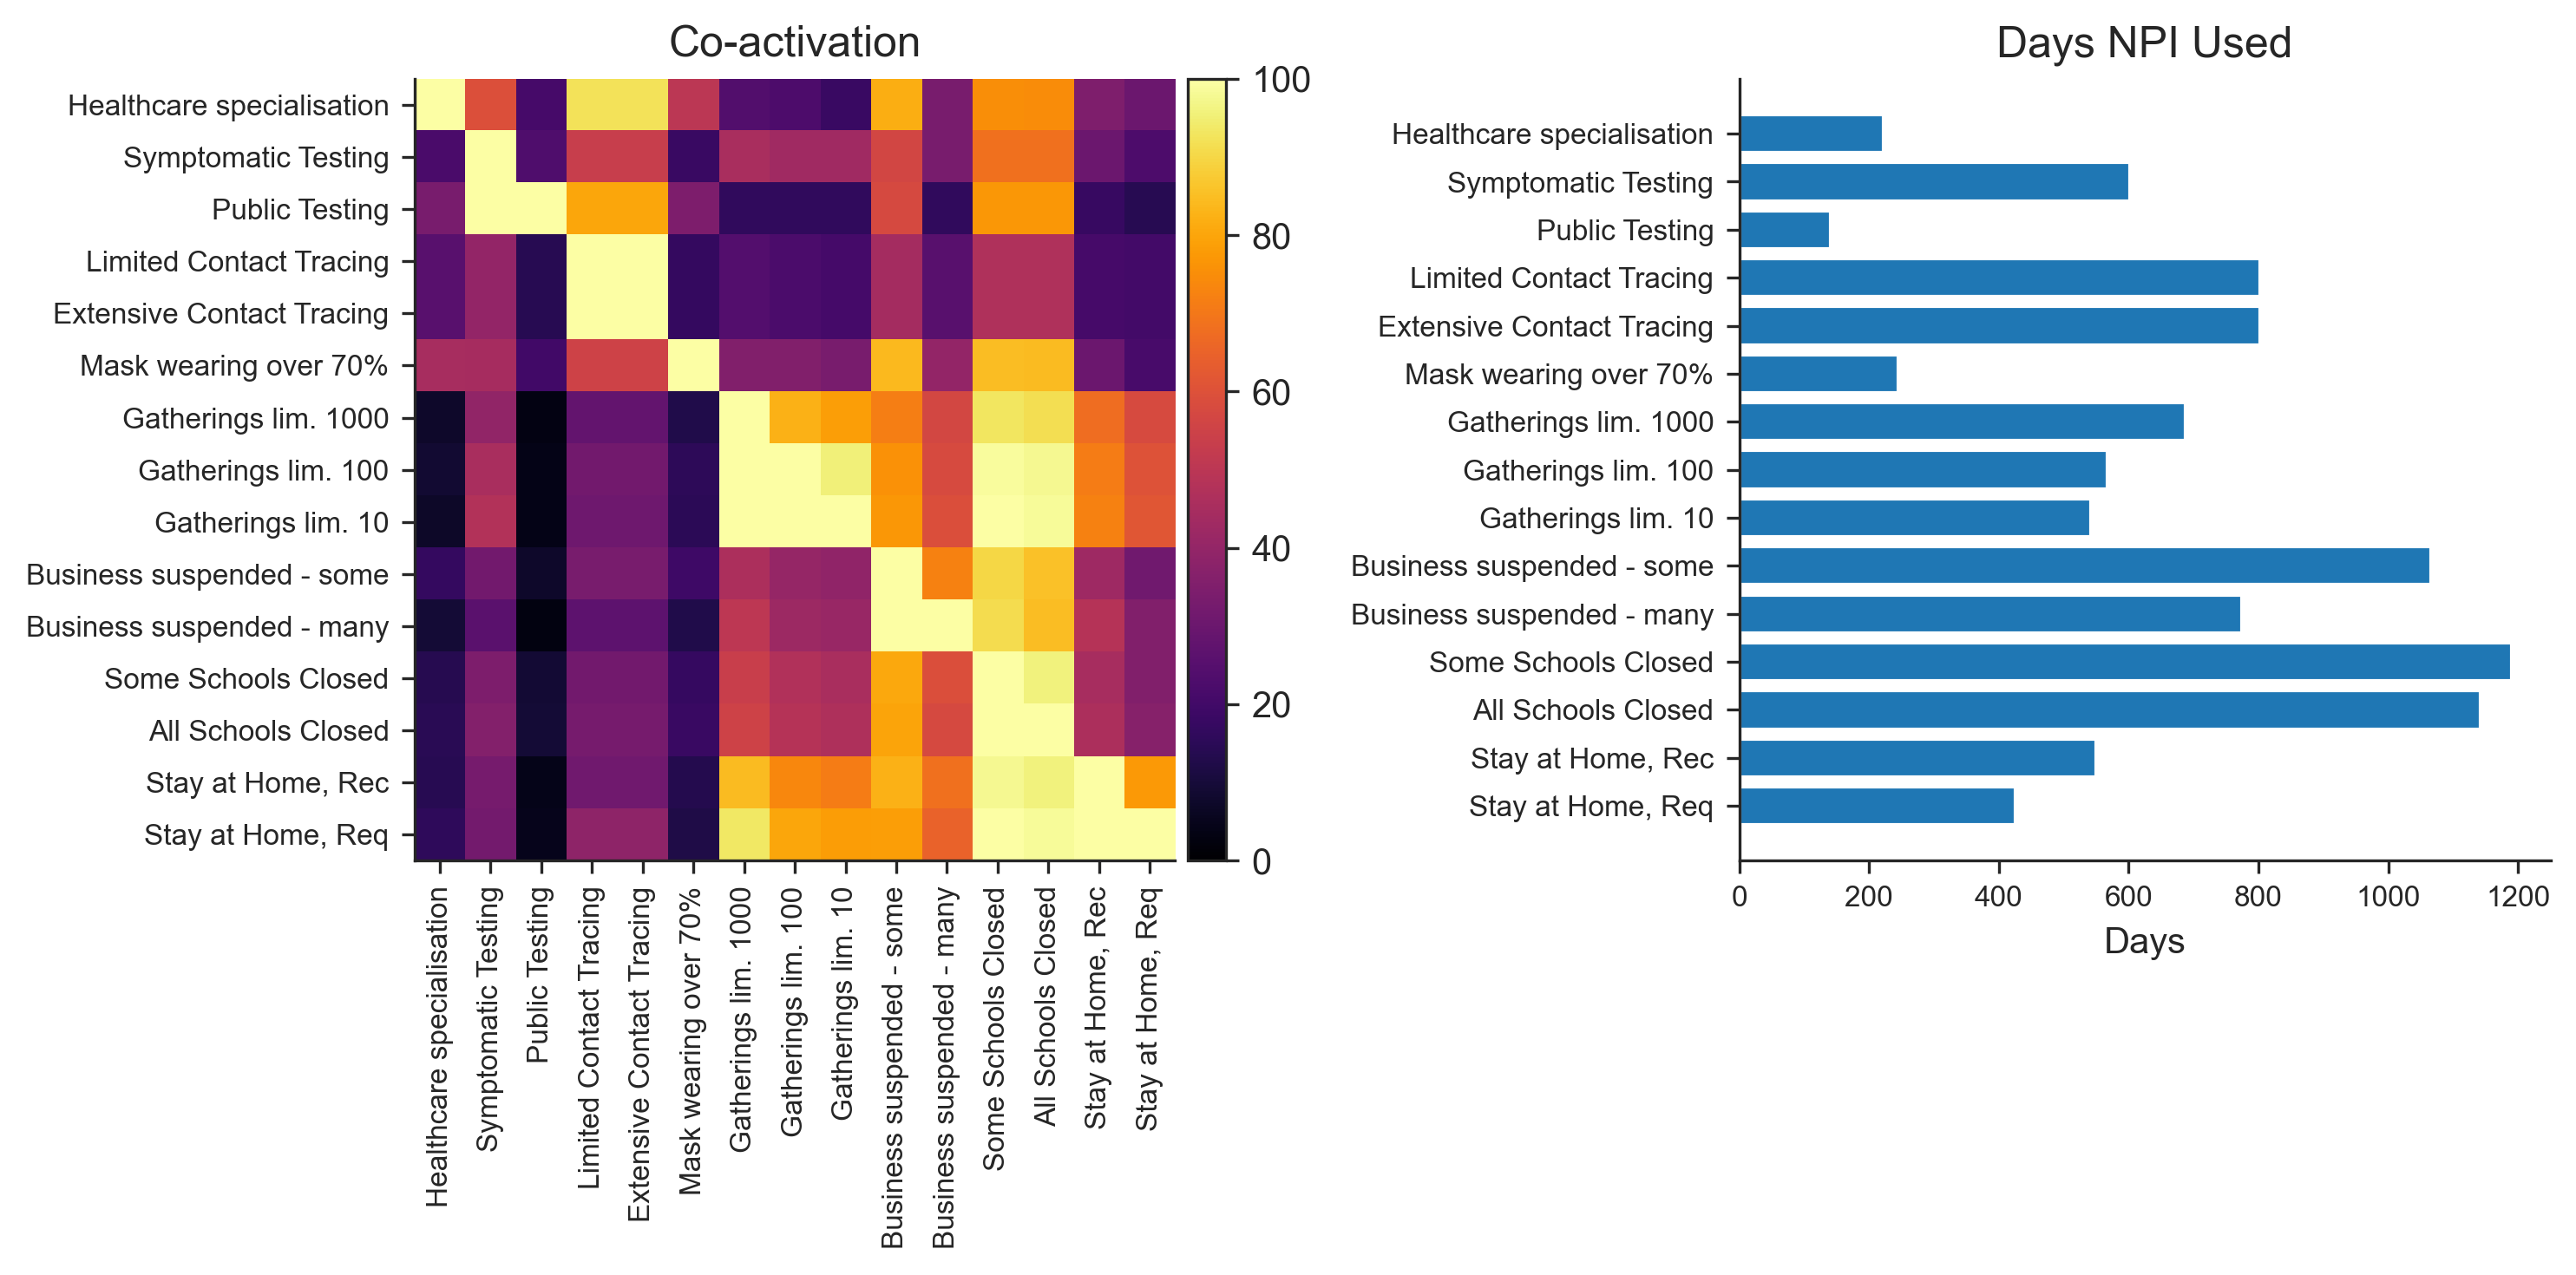

In [340]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.title("Co-activation")
ax = plt.gca()
mat = np.zeros((nCMs, nCMs))
for cm in range(nCMs):
    mask = ActiveCMs[:, cm, :]
    for cm2 in range(nCMs):
        mat[cm, cm2] = np.sum(mask * ActiveCMs[:, cm2, :]) / np.sum(mask)
im = plt.imshow(mat * 100, vmin=0, vmax=100, cmap="inferno", aspect="auto")
ax.tick_params(axis="both", which="major", labelsize=8)

plt.xticks(
    np.arange(len(final_features_ordered)),
    [f for f in final_features_ordered],
    rotation=90
)


plt.yticks(
    np.arange(len(final_features_ordered)),
    [f for f in final_features_ordered], 
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.subplot(1, 2, 2)
ax = plt.gca()
days_active = np.sum(np.sum(ActiveCMs, axis=0), axis=1)
plt.barh(-np.arange(nCMs), days_active)


plt.yticks(
    -np.arange(len(final_features_ordered)),
    [f for f in final_features_ordered], 
)

ax.tick_params(axis="both", which="major", labelsize=8)
plt.title("Days NPI Used")
plt.xlabel("Days")


plt.tight_layout()
sns.despine()

# Active CM Plot

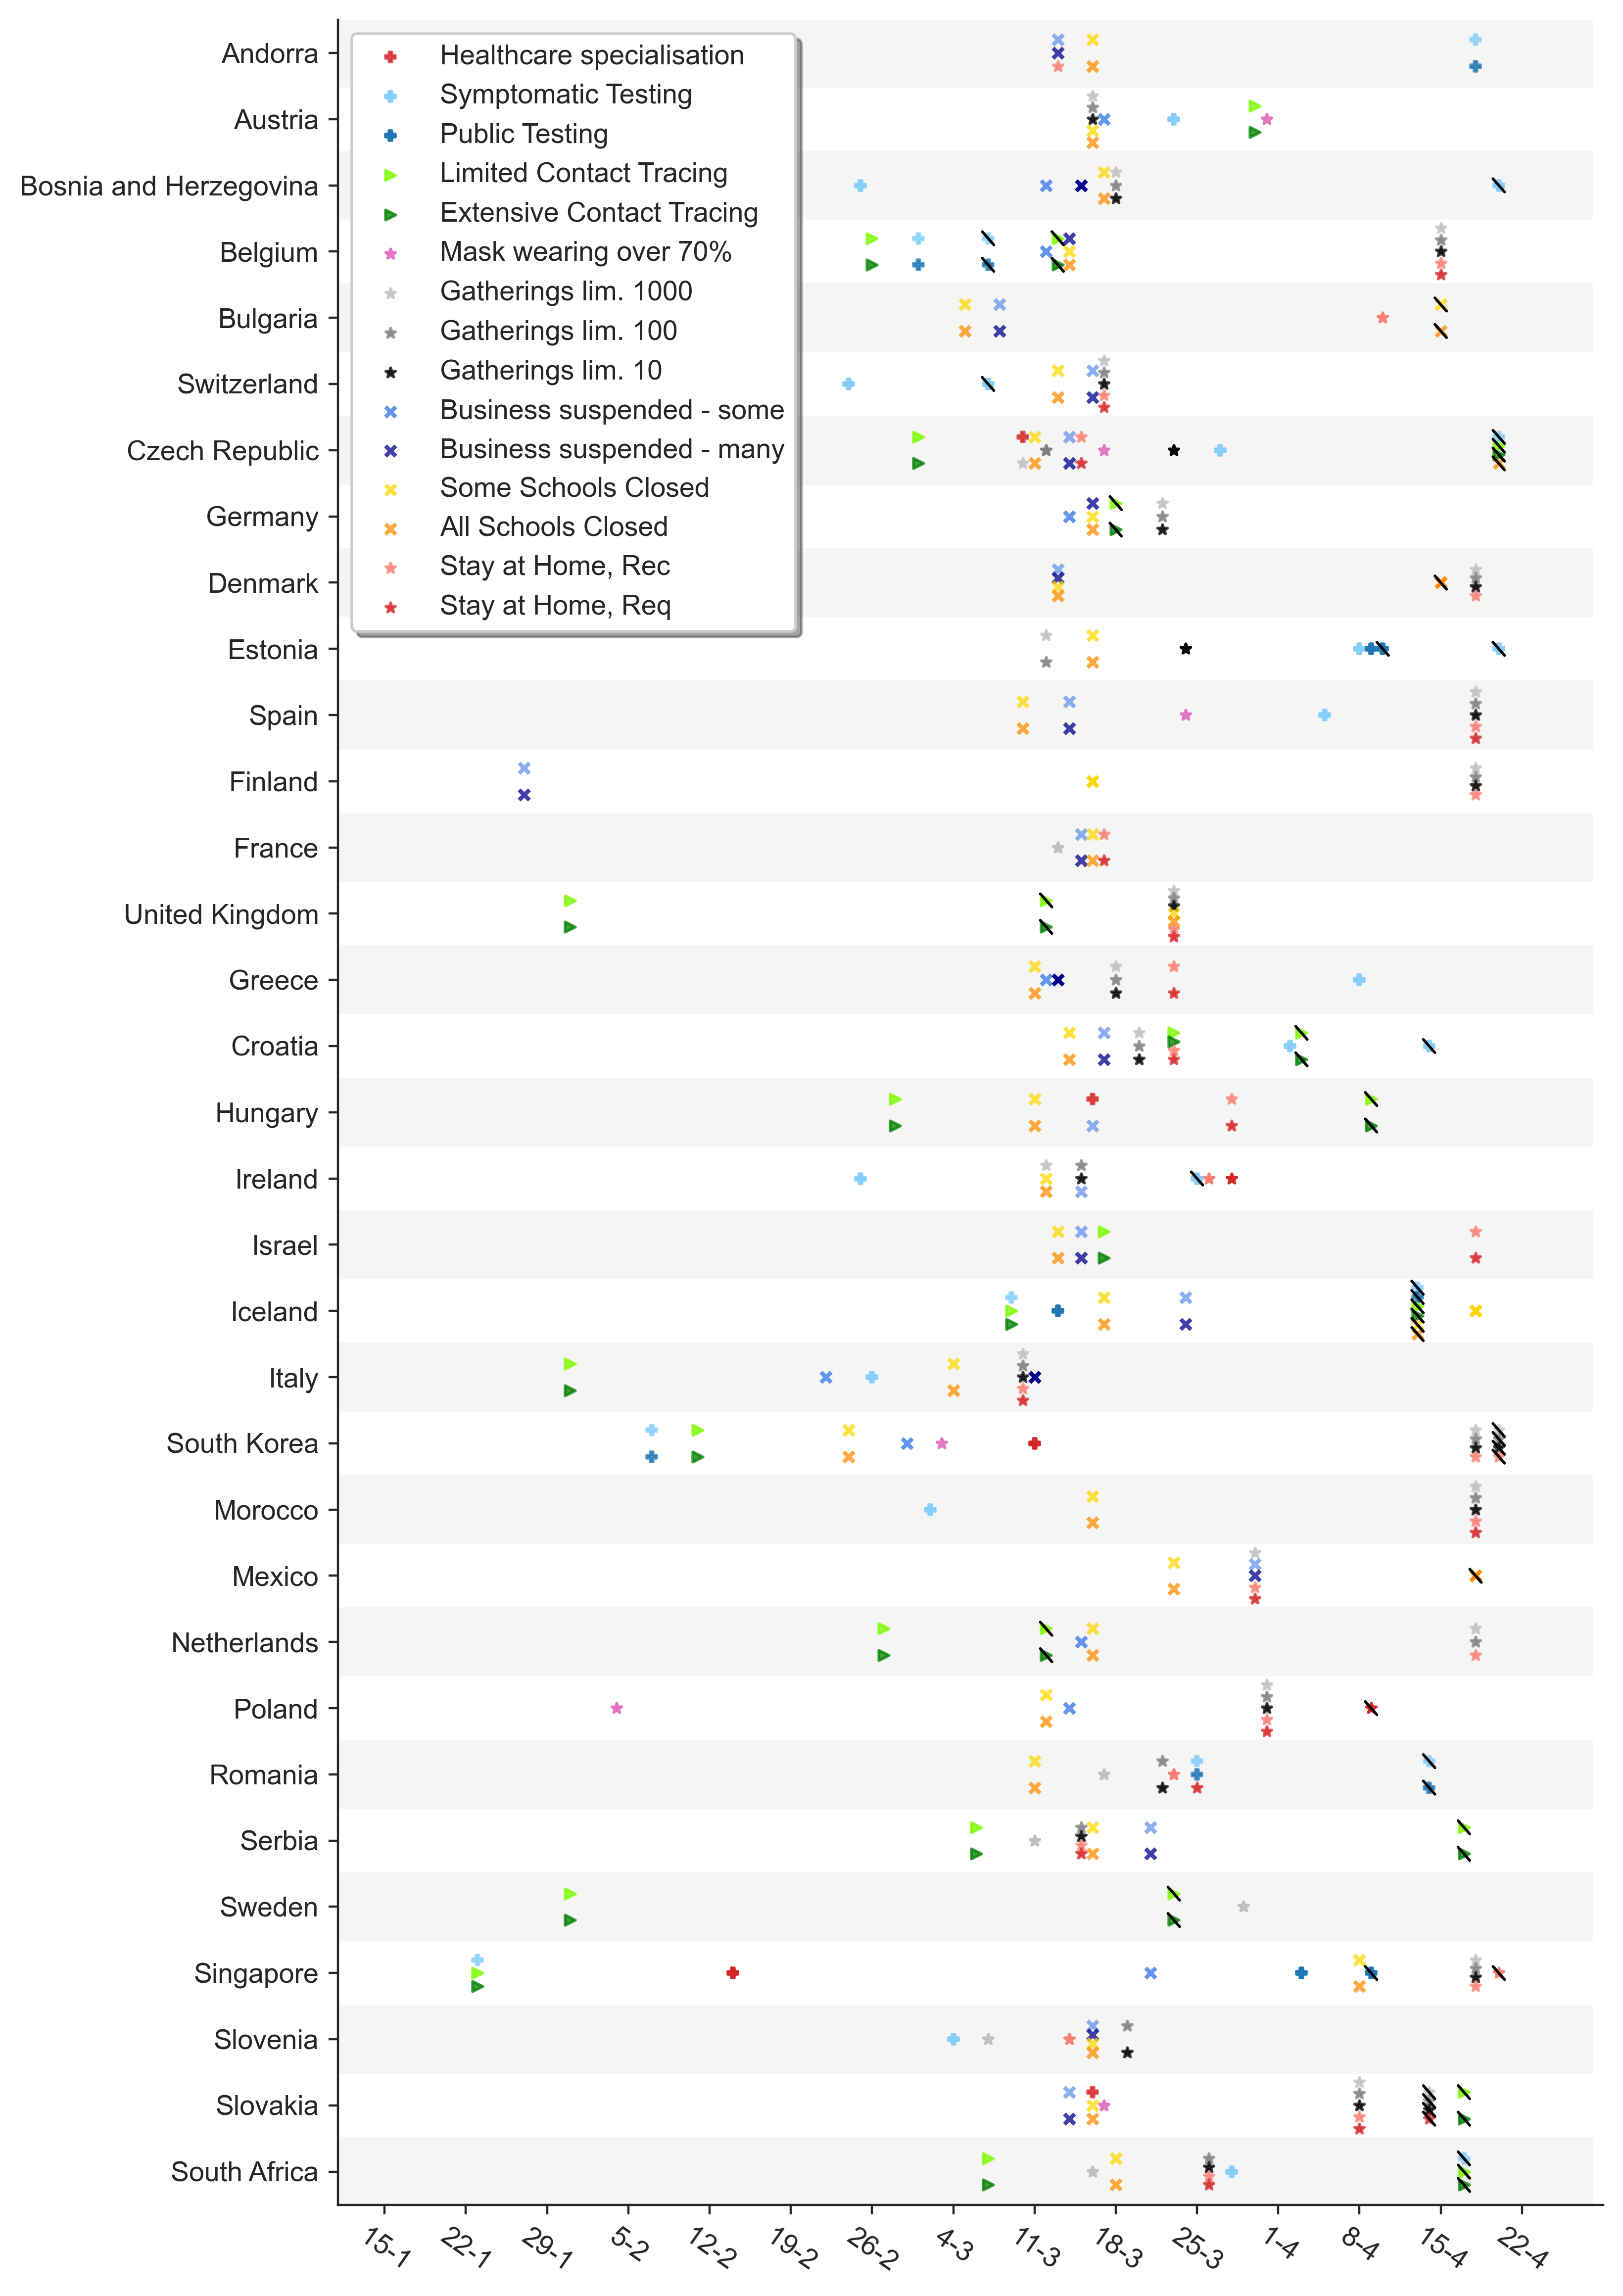

In [386]:
import seaborn as sns
sns.set_style("ticks")

region_names = list([x[0] for x in region_info])
region_last_updt = list([x[1] for x in region_info])
     
     # why no portugal? austrailia?

plot_style = [
    ("P", "tab:red"),
    ("P", "lightskyblue"),
    ("P", "tab:blue"),
    (">", "lawngreen"),
    (">", "green"),
    ("*", "tab:pink"),
    ("*", "silver"),
    ("*", "gray"),
    ("*", "black"),
    ("x", "cornflowerblue"),
    ("x", "darkblue"),
    ("x", "gold"),
    ("x", "darkorange"),
    ("*", "salmon"),
    ("*", "tab:red")
]
        
dts = data_filtered.loc["AT"].index
nDs = len(dts)
nRs = len(region_info)

x_min = 10
x_max = nDs

spread_small = 0.4
spread_large = 0.7

fig = plt.figure(figsize=(8.3, 11.7), dpi=400)

for height in range(0, nRs, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="whitesmoke")

feature_counts = np.zeros(len(final_features_ordered))
days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info):
    all_cm_values = ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    all_cm_changes = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(final_features_ordered):
        cm_values = all_cm_values[indx, :]
        cm_changes = cm_values[1:] - cm_values[:-1]
        nz = (np.nonzero(cm_changes)[0]+1).tolist()
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val-1]
            if all_changes > 1:
                if all_changes > 4:
                    spread = spread_large
                else:
                    spread = spread_small
                    
                height = (region_height + spread/2) - ((spread/(all_changes-1)) * cum_changes[nz_val-1])
                alpha = 0.75
                cum_changes[nz_val-1] += 1
            else:
                height = region_height
                alpha = 1
            
            if cm_changes[nz_val-1] == 1.0:
                if feature_counts[indx] == 0:
                    if indx > 0:
                        if feature_counts[indx - 1] > 0:
                            plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], label=final_features_ordered[indx], alpha=alpha)
                            feature_counts[indx] += 1
                        else:
                            plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
                    else:
                        plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], label=final_features_ordered[indx], alpha=alpha)
                        feature_counts[indx] += 1
                else:
                    plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
            else:
                plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
                plt.plot([nz_val-0.5, nz_val+0.5], [height+0.1, height-0.1], linewidth=1, color="black")
            
        
locs = np.arange(0, nDs, 7)
xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]

plt.xticks(locs, xlabels, rotation=-35)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(regions_names)), region_names)
plt.ylim([-nRs+0.5, 0.5])
plt.legend(fancybox=True, shadow=True)
sns.despine()
plt.tight_layout()
plt.savefig("time.pdf")